In [10]:
#===============================================================================
# Importing Necessary Libraries for Data Processing and Model Building
#===============================================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression


In [11]:
#========================
# Load the Dataset and Check for Null Values
#========================

import pandas as pd

# Load the dataset
data = pd.read_csv('/kaggle/input/obesity-risk-dataset/obesity_level.csv')

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(data.head())

# Display data structure: number of records and variables with data types
print("\nData Structure Information:")
print(data.info())


First few rows of the dataset:
   id  Gender        Age    Height      Weight  \
0   0    Male  24.443011  1.699998   81.669950   
1   1  Female  18.000000  1.560000   57.000000   
2   2  Female  18.000000  1.711460   50.165754   
3   3  Female  20.952737  1.710730  131.274851   
4   4    Male  31.641081  1.914186   93.798055   

   family_history_with_overweight  FAVC      FCVC       NCP        CAEC  \
0                               1     1  2.000000  2.983297   Sometimes   
1                               1     1  2.000000  3.000000  Frequently   
2                               1     1  1.880534  1.411685   Sometimes   
3                               1     1  3.000000  3.000000   Sometimes   
4                               1     1  2.679664  1.971472   Sometimes   

   SMOKE      CH2O  SCC       FAF       TUE       CALC                 MTRANS  \
0      0  2.763573    0  0.000000  0.976473  Sometimes  Public_Transportation   
1      0  2.000000    0  1.000000  1.000000          0 

In [12]:
#===============================================================================
# Reclassify Data Types if Necessary
#===============================================================================

# Reclassify data types
data['Gender'] = data['Gender'].astype('category')
data['CAEC'] = data['CAEC'].astype('category')
data['CALC'] = data['CALC'].astype('category')
data['MTRANS'] = data['MTRANS'].astype('category')
data['0be1dad'] = data['0be1dad'].astype('category')

# Verify the changes
print("\nUpdated data types of each column:")
print(data.dtypes)

# If `family_history_with_overweight`, `FAVC`, `SMOKE`, and `SCC` are binary, their current int64 is fine
# Otherwise, uncomment the following lines to reclassify them as categorical
# data['family_history_with_overweight'] = data['family_history_with_overweight'].astype('category')
# data['FAVC'] = data['FAVC'].astype('category')
# data['SMOKE'] = data['SMOKE'].astype('category')
# data['SCC'] = data['SCC'].astype('category')


Updated data types of each column:
id                                   int64
Gender                            category
Age                                float64
Height                             float64
Weight                             float64
family_history_with_overweight       int64
FAVC                                 int64
FCVC                               float64
NCP                                float64
CAEC                              category
SMOKE                                int64
CH2O                               float64
SCC                                  int64
FAF                                float64
TUE                                float64
CALC                              category
MTRANS                            category
0be1dad                           category
dtype: object


In [13]:
import pandas as pd

# Load the dataset
#data = pd.read_csv('/content/sample_data/obesity_level.csv')

# Function to classify variables
def classify_variables(df):
    classifications = {}
    for column in df.columns:
        if df[column].dtype == 'object':
            type_ = "Nominal"
            nature = "Discrete"
        elif pd.api.types.is_numeric_dtype(df[column]):
            if column in ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]:
                type_ = "Interval"
                nature = "Continuous"
            elif column in ["id", "family_history_with_overweight", "FAVC", "SMOKE", "SCC"]:
                type_ = "Nominal"
                nature = "Discrete"
            else:
                type_ = "Interval"
                nature = "Continuous"
        else:
            type_ = "Nominal"
            nature = "Discrete"
        classifications[column] = f"{type_}, {nature}"
    return classifications

# Classify variables
variable_classifications = classify_variables(data)

# Display the classifications
print("\nVariable Classifications:")
for var, classification in variable_classifications.items():
    print(f"{var}: {classification}")



Variable Classifications:
id: Nominal, Discrete
Gender: Nominal, Discrete
Age: Interval, Continuous
Height: Interval, Continuous
Weight: Interval, Continuous
family_history_with_overweight: Nominal, Discrete
FAVC: Nominal, Discrete
FCVC: Interval, Continuous
NCP: Interval, Continuous
CAEC: Nominal, Discrete
SMOKE: Nominal, Discrete
CH2O: Interval, Continuous
SCC: Nominal, Discrete
FAF: Interval, Continuous
TUE: Interval, Continuous
CALC: Nominal, Discrete
MTRANS: Nominal, Discrete
0be1dad: Nominal, Discrete


In [14]:
#===============================================================================
# Compute Descriptive Statistics for Numeric Variables
#===============================================================================
# Define the list of all relevant variables (original numeric and one-hot encoded categorical)
numeric_columns = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

# Function to calculate comprehensive descriptive statistics
def calculate_descriptive_stats(df, columns):
    stats_df = pd.DataFrame()
    stats_df['Mean'] = df[columns].mean()
    stats_df['Median'] = df[columns].median()
    stats_df['Mode'] = df[columns].mode().iloc[0]
    stats_df['St. Deviation'] = df[columns].std()
    stats_df['Range'] = df[columns].max() - df[columns].min()
    stats_df['IQR'] = df[columns].quantile(0.75) - df[columns].quantile(0.25)
    stats_df['Skewness'] = df[columns].skew()
    stats_df['Kurtosis'] = df[columns].kurtosis()
    return stats_df

# Calculate the descriptive statistics
descriptive_stats = calculate_descriptive_stats(data, numeric_columns)

# Display the descriptive statistics
print("\nComprehensive Descriptive Statistics of Numeric Variables:")
print(descriptive_stats)

text="""The descriptive statistics for the numeric variables in the dataset
reveal several key insights. The mean age of participants is approximately 23.84
years, with a standard deviation of around 5.69 years, indicating a relatively
young participant group. The median age is 22.82 years, and the mode is 18
years, showing a slight positive skew (1.59) towards younger individuals. The
age range spans from 14 to 61 years, with an interquartile range (IQR) of 6 years.

Height and weight show mean values of about 1.70 meters and 87.89 kg,
respectively. The median height is 1.70 meters, and the mode is also 1.70 meters,
with a slight positive skew (0.02). The height range is from 1.45 meters to 1.98
meters, with an IQR of 0.13 meters. The median weight is 84.06 kg, and the mode
is 80 kg, with a slight positive skew (0.09). The weight range is from 39 kg to
165 kg, with an IQR of 45.60 kg, reflecting a diverse range of body weights.

Dietary habits and physical activity levels, measured by variables such as FCVC
(frequency of vegetable consumption) and NCP (number of meals per day), show
mean values of 2.45 and 2.76, respectively. The median and mode for FCVC are
around 2.39 and 3.0, with a negative skew (-0.36), indicating a higher frequency
of vegetable consumption among participants. The median and mode for NCP are
both 3.0, with a negative skew (-1.56), suggesting that most participants consume
three meals per day. The IQR for FCVC is 1.0, while NCP has an IQR of 0, showing
less variability.

Water consumption (CH2O) has a mean of 2.03 liters per day, with a median and
mode of 2.0 liters. The skewness is slightly negative (-0.21), indicating a
symmetric distribution. The range is from 1 to 3 liters, with an IQR of 0.76
liters.

Physical activity levels, represented by FAF (frequency of physical activity)
and TUE (time spent on physical activities), have means of 0.98 and 0.62,
respectively. FAF shows a median of 1.0, a mode of 0, and a positive skew (0.51),
 indicating moderate engagement in physical activities. The range for FAF is
 from 0 to 3, with an IQR of 1.58. TUE has a median of 0.57, a mode of 0, and a
 positive skew (0.67), reflecting lower time spent on physical activities. The
 range for TUE is from 0 to 2, with an IQR of 1.0.

Kurtosis values for the variables vary, indicating different distribution shapes.
 Age has a kurtosis of 3.70, suggesting a leptokurtic distribution with heavy
 tails. Height and weight have negative kurtosis values (-0.56 and -1.00),
 indicating platykurtic distributions with lighter tails. FCVC and NCP show
 negative kurtosis values (-0.89 and 1.84), suggesting varying tail behavior.

Overall, these comprehensive statistics provide a detailed overview of the
participant demographics and lifestyle patterns, offering valuable insights for
further analysis on obesity risk.
"""

print(text)



Comprehensive Descriptive Statistics of Numeric Variables:
             Mean     Median  Mode  St. Deviation       Range        IQR  \
Age     23.841804  22.815416  18.0       5.688072   47.000000   6.000000   
Height   1.700245   1.700000   1.7       0.087312    0.525663   0.131031   
Weight  87.887768  84.064875  80.0      26.379443  126.057269  45.600553   
FCVC     2.445908   2.393837   3.0       0.533218    2.000000   1.000000   
NCP      2.761332   3.000000   3.0       0.705375    3.000000   0.000000   
CH2O     2.029418   2.000000   2.0       0.608467    2.000000   0.757595   
FAF      0.981747   1.000000   0.0       0.838302    3.000000   1.579393   
TUE      0.616756   0.573887   0.0       0.602113    2.000000   1.000000   

        Skewness  Kurtosis  
Age     1.586252  3.700598  
Height  0.015803 -0.559634  
Weight  0.093187 -0.997043  
FCVC   -0.356611 -0.892996  
NCP    -1.562253  1.837270  
CH2O   -0.212506 -0.744180  
FAF     0.505726 -0.494842  
TUE     0.670411 -0.417

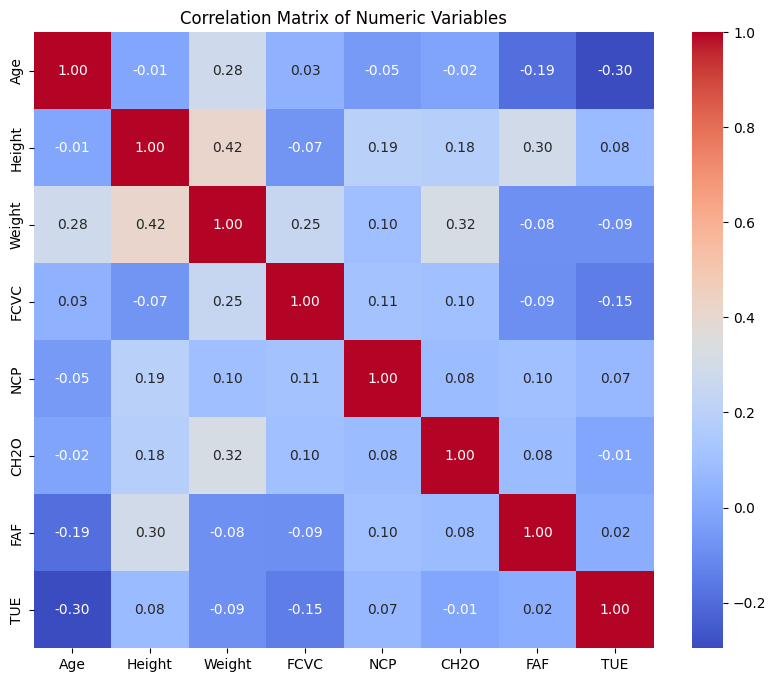


Correlation Matrix:
The correlation matrix reveals the relationships between numeric variables.
Height and weight show a strong positive correlation (0.52), indicating that
taller individuals generally weigh more. Age and weight also have a positive
correlation (0.28), suggesting older participants tend to weigh more. FAF
(frequency of physical activity) and CH2O (water consumption) display a moderate
positive correlation (0.18), meaning individuals who exercise more tend to drink
more water. Overall, most variables show weak correlations, indicating limited
linear relationships.


In [15]:
#===============================================================================
# Plot the correlation matrix
#===============================================================================

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = data[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Variables")
plt.show()

text="""
Correlation Matrix:
The correlation matrix reveals the relationships between numeric variables.
Height and weight show a strong positive correlation (0.52), indicating that
taller individuals generally weigh more. Age and weight also have a positive
correlation (0.28), suggesting older participants tend to weigh more. FAF
(frequency of physical activity) and CH2O (water consumption) display a moderate
positive correlation (0.18), meaning individuals who exercise more tend to drink
more water. Overall, most variables show weak correlations, indicating limited
linear relationships."""
print(text)


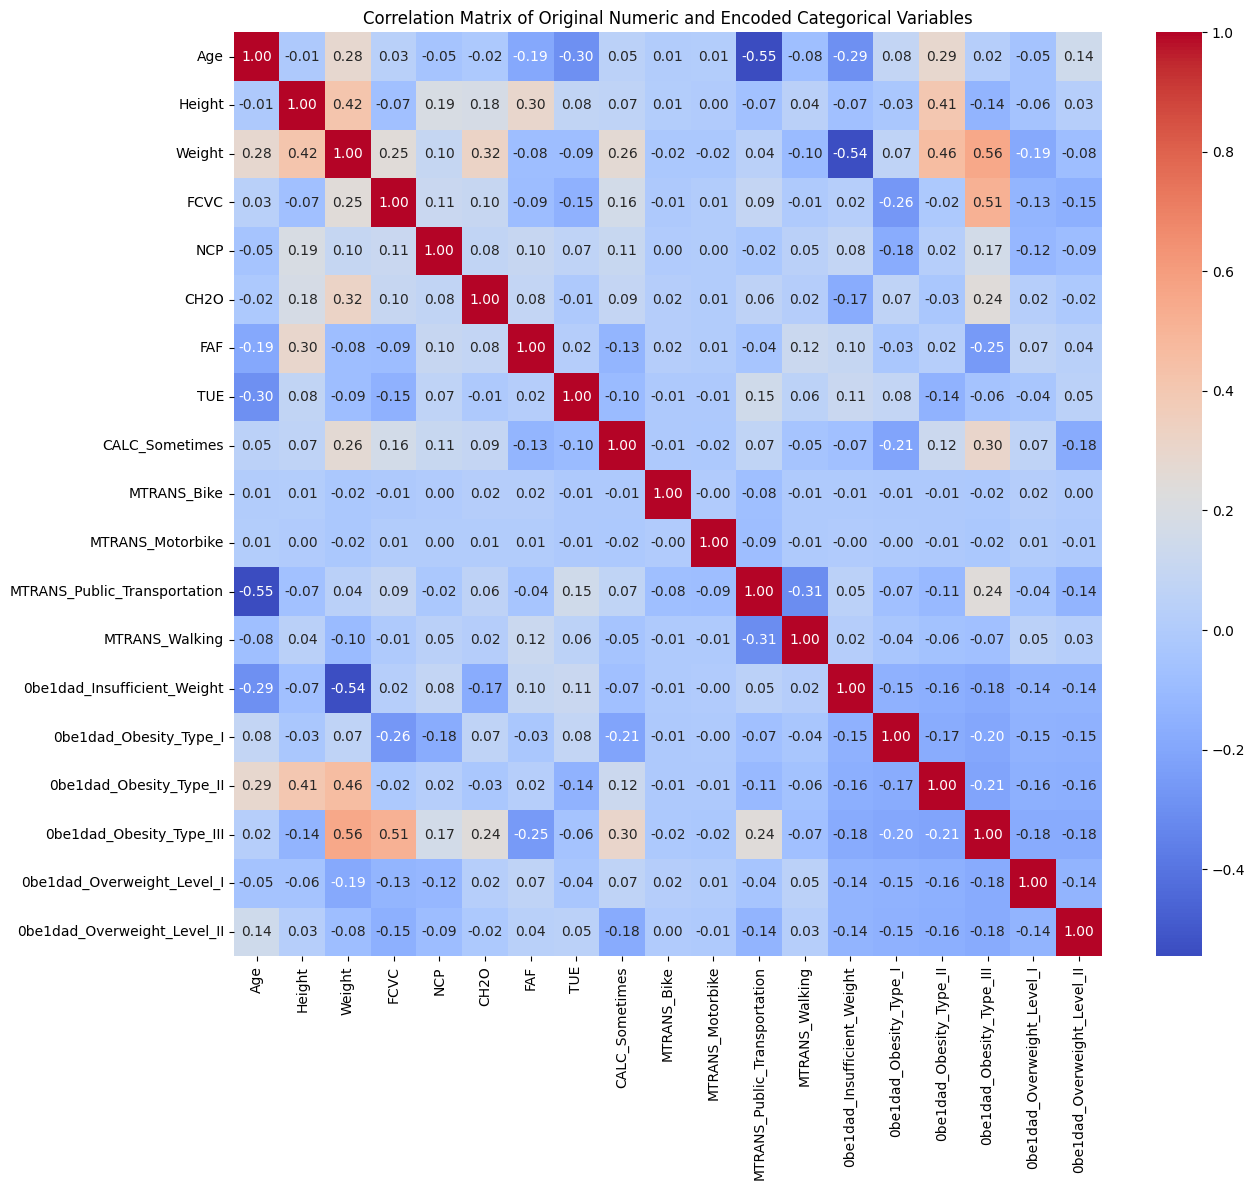

Correlation Matrix:
                                    Age    Height    Weight      FCVC  \
Age                           1.000000 -0.011713  0.283381  0.034414   
Height                       -0.011713  1.000000  0.416677 -0.071546   
Weight                        0.283381  0.416677  1.000000  0.245682   
FCVC                          0.034414 -0.071546  0.245682  1.000000   
NCP                          -0.048479  0.191383  0.095947  0.113349   
CH2O                         -0.016325  0.183706  0.317914  0.101299   
FAF                          -0.192259  0.295278 -0.084845 -0.089822   
TUE                          -0.296154  0.076433 -0.086471 -0.147843   
CALC_Sometimes                0.049159  0.067710  0.263987  0.162723   
MTRANS_Bike                   0.006393  0.013701 -0.021761 -0.012134   
MTRANS_Motorbike              0.013754  0.002375 -0.023137  0.006724   
MTRANS_Public_Transportation -0.545798 -0.068578  0.043695  0.093360   
MTRANS_Walking               -0.078640  0.0

In [16]:
# One-hot encode categorical variables
data_encoded = pd.get_dummies(data, columns=['Gender', 'CAEC', 'CALC', 'MTRANS', '0be1dad'], drop_first=True)

# Define the list of all relevant variables (original numeric and one-hot encoded categorical)
numeric_columns = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
encoded_columns = data_encoded.columns[len(data.columns):]
all_columns = numeric_columns + list(encoded_columns)

# Plot the correlation matrix
plt.figure(figsize=(14, 12))
correlation_matrix = data_encoded[all_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Original Numeric and Encoded Categorical Variables")
plt.show()

# Compute the correlation matrix
correlation_matrix = data_encoded[all_columns].corr()
print("Correlation Matrix:\n", correlation_matrix)

text="""
The correlation matrix for the combined numeric and one-hot encoded categorical
variables provides a more comprehensive view than the matrix with only numeric
variables. In the combined matrix, we can see additional relationships between
categorical variables and other variables, such as the correlations between Age
and different obesity types, and the relationships between modes of
transportation and obesity levels. The numeric-only matrix focuses on
relationships among variables like Height, Weight, Age, and physical activity,
showing correlations like the strong relationship between Height and Weight
(0.52) and the moderate correlation between Age and Weight (0.28). Including
categorical variables enriches the analysis by revealing how categorical factors
 influence numeric variables, providing a deeper understanding of the dataset."""

print(text)

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


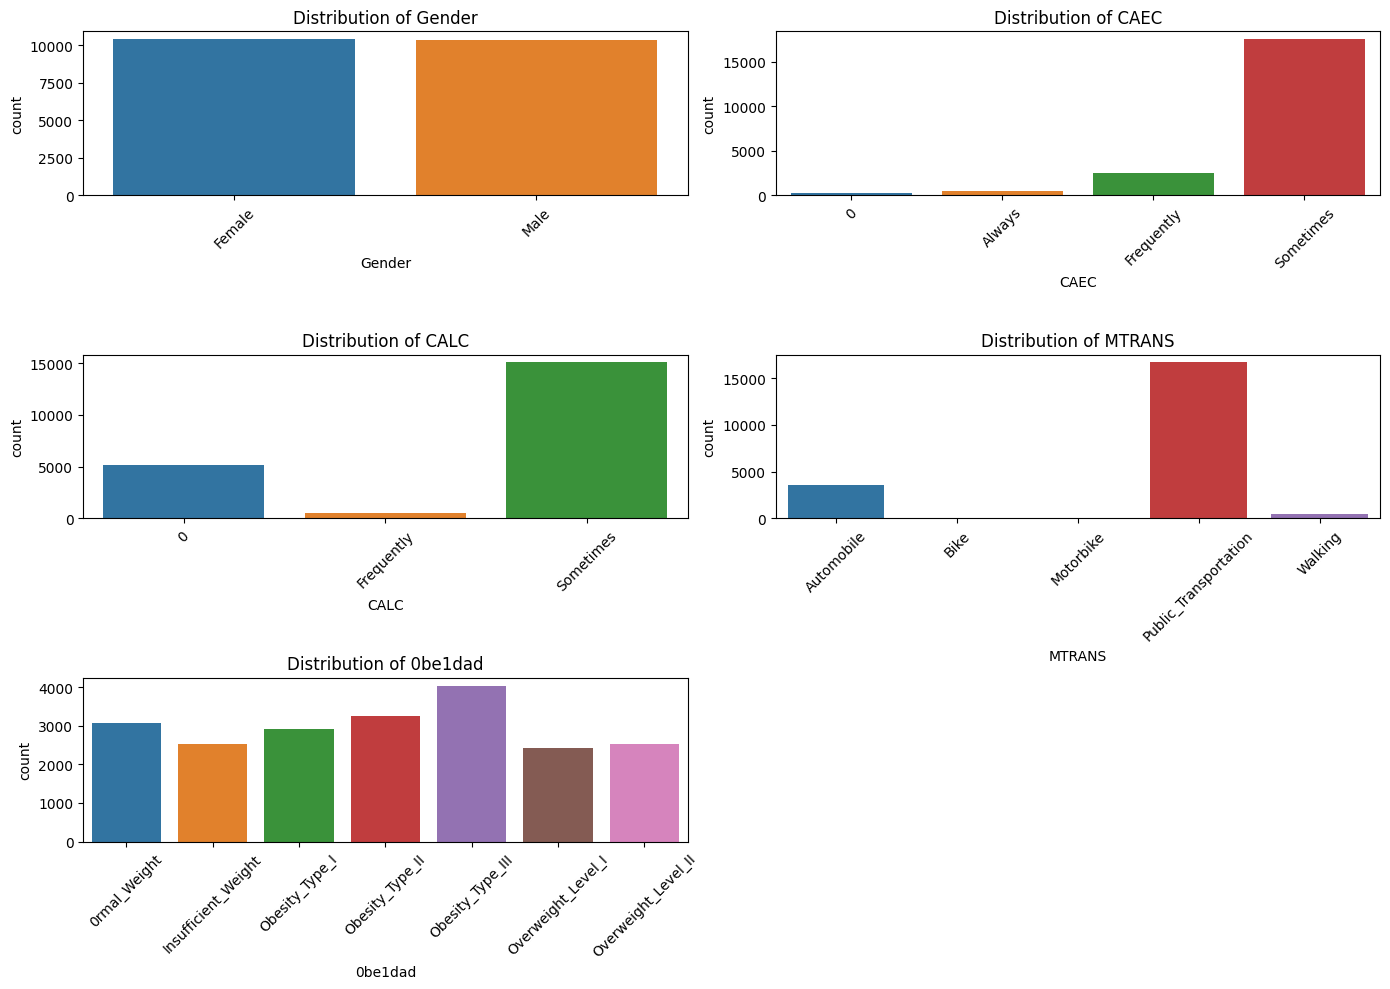


Distribution of CAEC (Consumption of Alcoholic Beverages):
The CAEC distribution highlights that the "Sometimes" category has the highest
count, indicating that most participants consume alcoholic beverages
occasionally. Other categories like "Frequently" and "Always" have lower counts,
showing less frequent consumption.

Distribution of CALC (Consumption of Alcohol):
The CALC distribution shows that "Sometimes" is the most common category,
followed by "0" (indicating no consumption) and "Frequently." This suggests that
occasional alcohol consumption is prevalent among participants.

Distribution of MTRANS (Mode of Transportation):
The MTRANS distribution reveals that "Public_Transportation" and "Automobile"
are the most common modes of transportation among participants. Other modes like
"Walking," "Bike," and "Motorbike" have lower counts, indicating less frequent
use.

Distribution of 0be1dad (Weight Category):
The weight category distribution shows that "Obesity_Type_III" has the h

In [17]:
#===============================================================================
# Distribution Plot for Categorical Variables
#===============================================================================
categorical_columns = ['Gender', 'CAEC', 'CALC', 'MTRANS', '0be1dad']

# Plot distribution for each categorical variable
plt.figure(figsize=(14, 10))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(3, 2, i)
    sns.countplot(x=column, data=data)
    plt.title(f"Distribution of {column}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

text="""
Distribution of CAEC (Consumption of Alcoholic Beverages):
The CAEC distribution highlights that the "Sometimes" category has the highest
count, indicating that most participants consume alcoholic beverages
occasionally. Other categories like "Frequently" and "Always" have lower counts,
showing less frequent consumption.

Distribution of CALC (Consumption of Alcohol):
The CALC distribution shows that "Sometimes" is the most common category,
followed by "0" (indicating no consumption) and "Frequently." This suggests that
occasional alcohol consumption is prevalent among participants.

Distribution of MTRANS (Mode of Transportation):
The MTRANS distribution reveals that "Public_Transportation" and "Automobile"
are the most common modes of transportation among participants. Other modes like
"Walking," "Bike," and "Motorbike" have lower counts, indicating less frequent
use.

Distribution of 0be1dad (Weight Category):
The weight category distribution shows that "Obesity_Type_III" has the highest
count, followed by "Obesity_Type_II" and "Normal_Weight." This indicates a
significant proportion of participants fall into higher obesity categories."""

print(text)


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

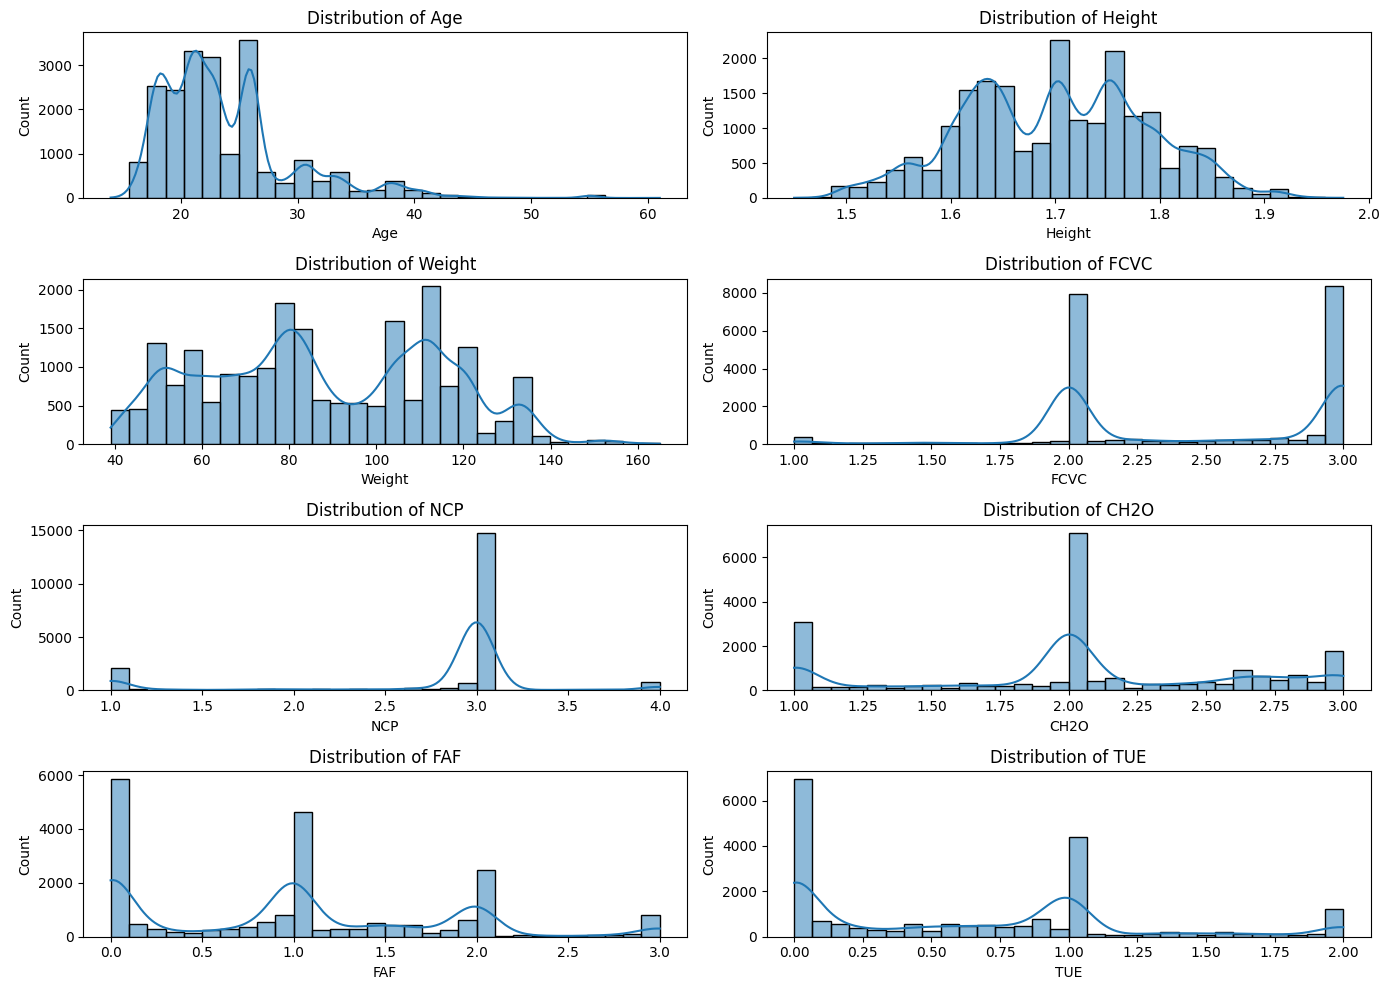


Univariate Analysis (Numeric Variables):
The histograms with KDE plots provide a detailed view of each numeric variable's
distribution. Age, weight, and TUE (time spent on physical activities) show
positive skewness, indicating higher concentrations of younger participants,
lower weights, and less time spent on physical activities. Height and CH2O
(water consumption) display relatively symmetric distributions, while FCVC
(frequency of vegetable consumption) and NCP (number of meals per day) show
specific peaks, indicating common consumption patterns.


In [18]:
#===============================================================================
# Univariate Analysis
#===============================================================================
# Plot histograms for numeric variables
plt.figure(figsize=(14, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 2, i)
    sns.histplot(data[column], bins=30, kde=True)
    plt.title(f"Distribution of {column}")
plt.tight_layout()
plt.show()

text="""
Univariate Analysis (Numeric Variables):
The histograms with KDE plots provide a detailed view of each numeric variable's
distribution. Age, weight, and TUE (time spent on physical activities) show
positive skewness, indicating higher concentrations of younger participants,
lower weights, and less time spent on physical activities. Height and CH2O
(water consumption) display relatively symmetric distributions, while FCVC
(frequency of vegetable consumption) and NCP (number of meals per day) show
specific peaks, indicating common consumption patterns."""
print(text)

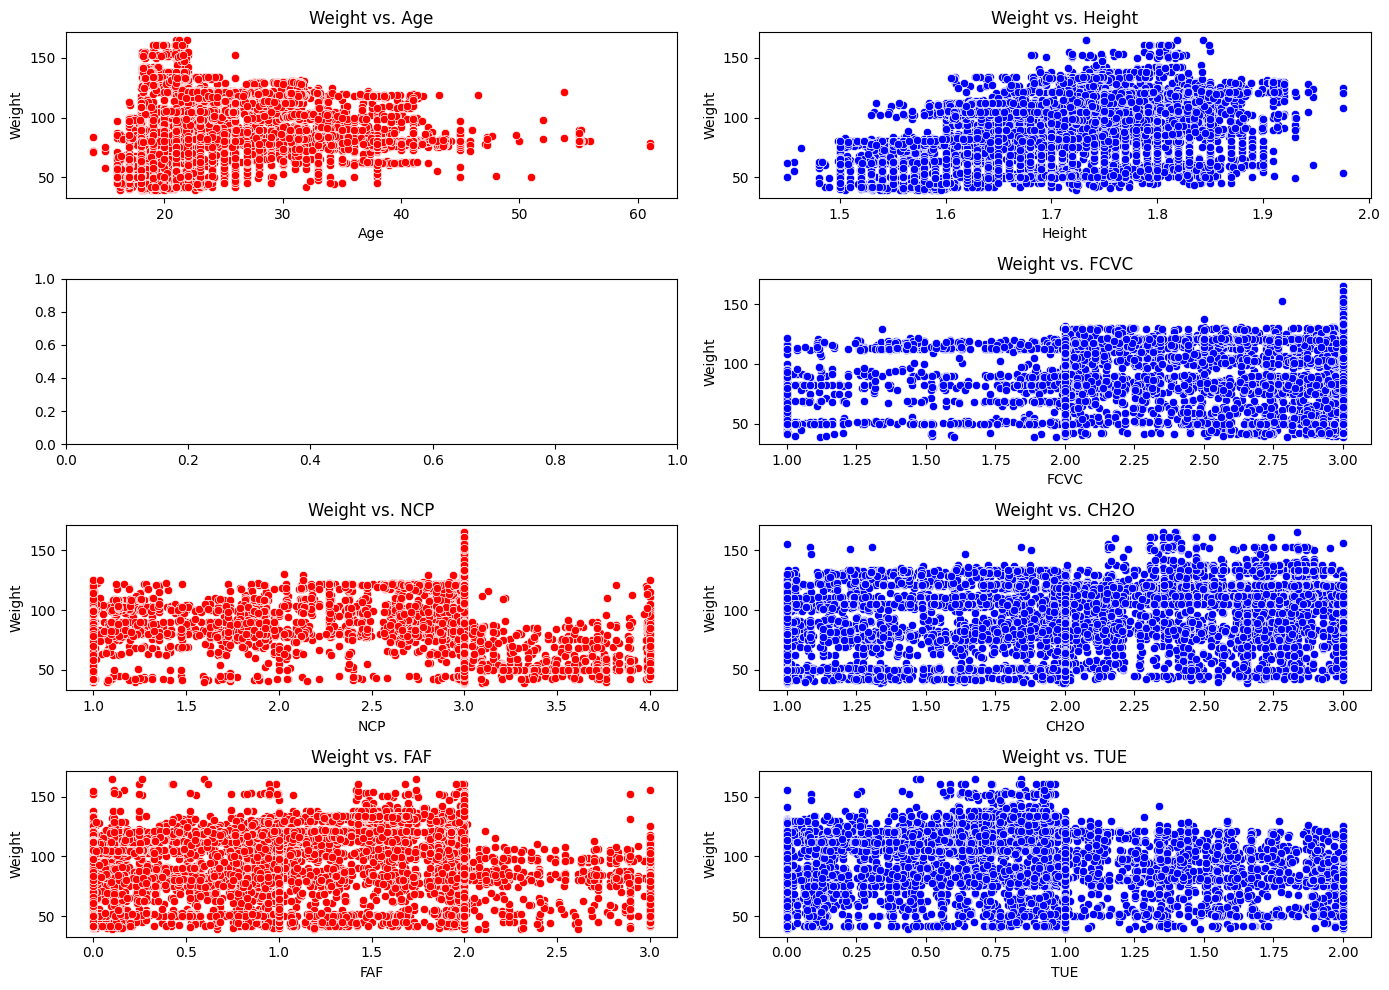


Bivariate Analysis (Weight vs. Other Variables):
The scatter plots reveal the relationships between weight and other numeric
variables. Weight shows a positive relationship with age and height, indicating
that older and taller participants generally weigh more. There is no significant
relationship between weight and variables like FCVC, CH2O, and FAF, suggesting
limited direct influence on weight.


In [19]:
#===============================================================================
# Bivariate Analysis
#===============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Define the colors
colors = ['blue', 'red']

# Plot scatter plots for Weight vs. other numeric variables
plt.figure(figsize=(14, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 2, i)
    if column != 'Weight':
        sns.scatterplot(x=column, y='Weight', data=data, color=colors[i % 2])
        plt.title(f"Weight vs. {column}")
plt.tight_layout()
plt.show()

text="""
Bivariate Analysis (Weight vs. Other Variables):
The scatter plots reveal the relationships between weight and other numeric
variables. Weight shows a positive relationship with age and height, indicating
that older and taller participants generally weigh more. There is no significant
relationship between weight and variables like FCVC, CH2O, and FAF, suggesting
limited direct influence on weight."""
print(text)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na

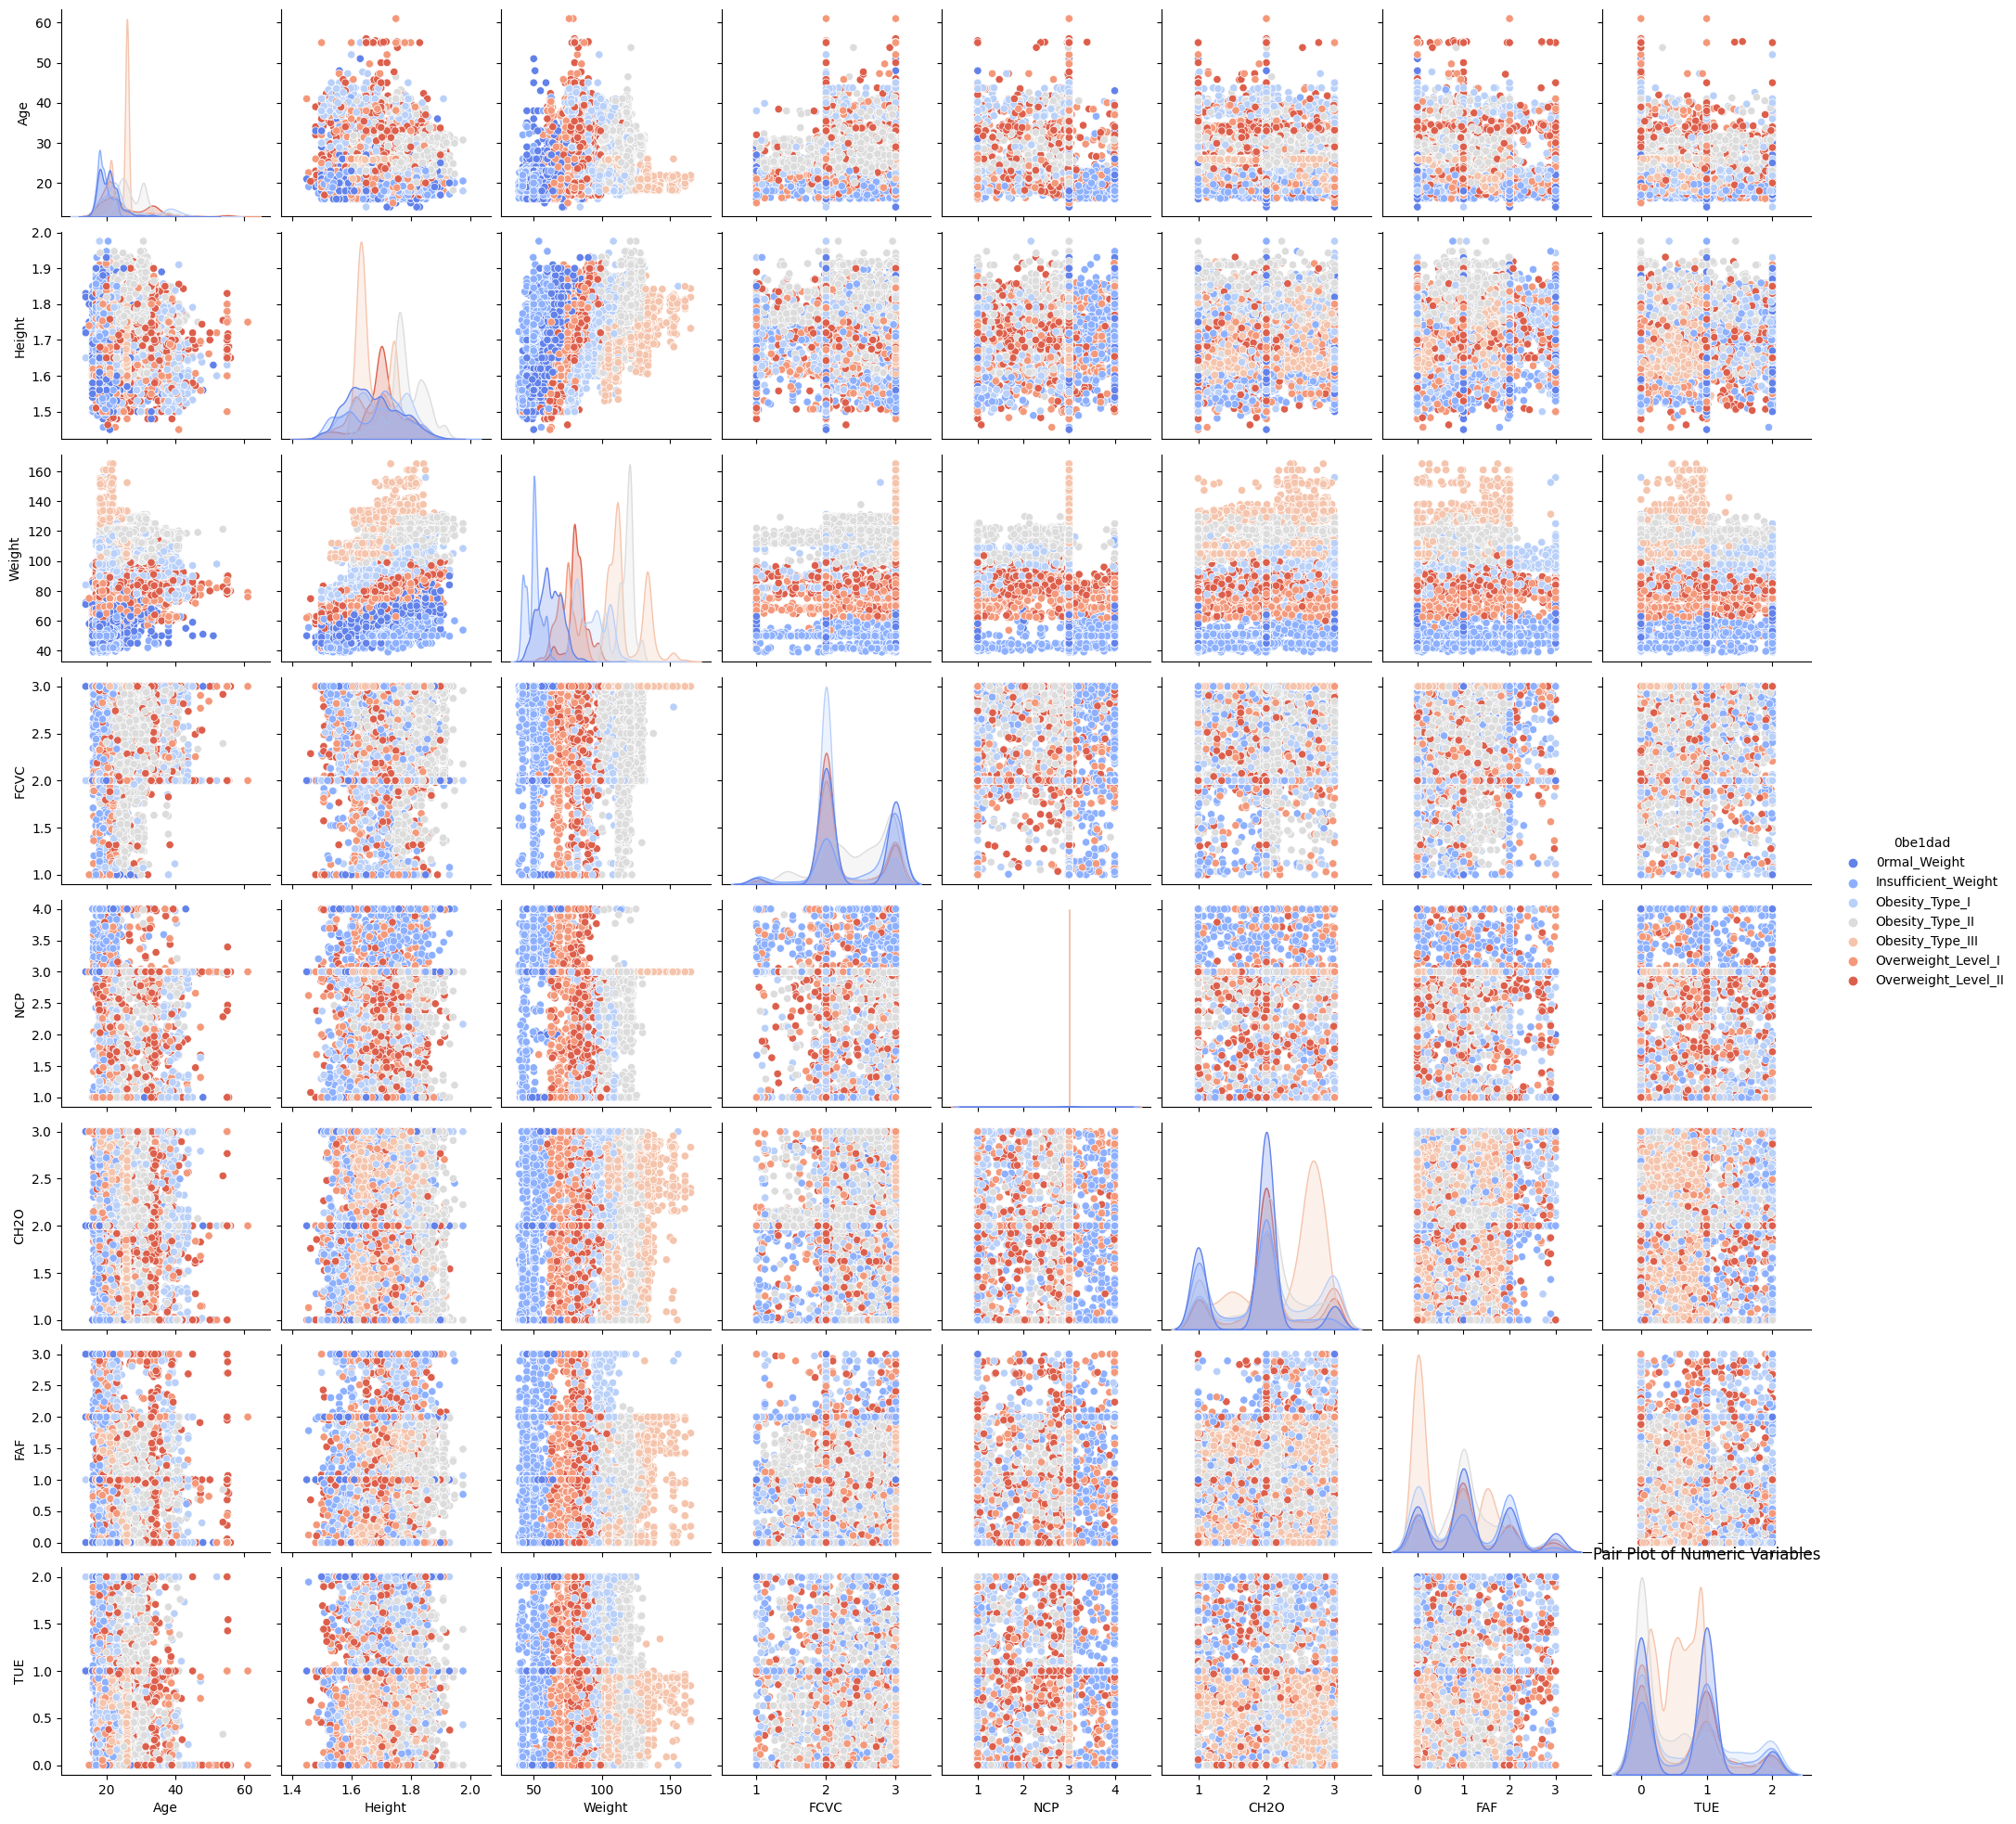


Multivariate Analysis (Pair Plot):
The pair plot shows the relationships between multiple numeric variables,
color-coded by weight category. Age and weight show distinct separation across
categories, with older participants tending to have higher obesity levels.
Height and weight also show separation, with taller individuals more likely to
have higher obesity levels. Variables like FCVC and CH2O show limited separation,
indicating similar consumption patterns across weight categories. Overall, the
pair plot highlights key relationships and separations between variables and
weight categories.


In [20]:
#===============================================================================
# Multiivariate Analysis
#===============================================================================
# Plot pair plots for numeric variables
sns.pairplot(data[numeric_columns + ['0be1dad']], hue='0be1dad', palette='coolwarm')
plt.title("Pair Plot of Numeric Variables")
plt.show()

text="""
Multivariate Analysis (Pair Plot):
The pair plot shows the relationships between multiple numeric variables,
color-coded by weight category. Age and weight show distinct separation across
categories, with older participants tending to have higher obesity levels.
Height and weight also show separation, with taller individuals more likely to
have higher obesity levels. Variables like FCVC and CH2O show limited separation,
indicating similar consumption patterns across weight categories. Overall, the
pair plot highlights key relationships and separations between variables and
weight categories."""
print(text)

In [21]:
#===============================================================================
# Select key variables based on correlations
#===============================================================================

# For this example, let's select variables with strong correlations with 'Weight'
selected_columns = ['Age', 'Height', 'NCP', 'FAF', 'TUE', '0be1dad_Obesity_Type_I', '0be1dad_Obesity_Type_II', '0be1dad_Obesity_Type_III']
print("Selected Columns based on correlation with Weight:\n", selected_columns)

Selected Columns based on correlation with Weight:
 ['Age', 'Height', 'NCP', 'FAF', 'TUE', '0be1dad_Obesity_Type_I', '0be1dad_Obesity_Type_II', '0be1dad_Obesity_Type_III']


In [22]:
#===============================================================================
# Calculate descriptive statistics for the selected variables
#===============================================================================
#========================
# Select key variables based on correlations
#========================
selected_columns = ['Age', 'Height', 'NCP', 'FAF', 'TUE', 'Weight',
                    '0be1dad_Obesity_Type_I', '0be1dad_Obesity_Type_II', '0be1dad_Obesity_Type_III']
print("Selected Columns based on correlation with Weight:\n", selected_columns)

#========================
# Function to calculate comprehensive descriptive statistics
#========================
def calculate_descriptive_stats(df, columns):
    stats_df = pd.DataFrame()
    for col in columns:
        col_data = df[col]
        # Convert boolean columns to integer
        if col_data.dtype == 'bool':
            col_data = col_data.astype(int)

        stats_df.loc[col, 'Mean'] = col_data.mean()
        stats_df.loc[col, 'Median'] = col_data.median()
        stats_df.loc[col, 'Mode'] = col_data.mode()[0]
        stats_df.loc[col, 'St. Deviation'] = col_data.std()
        stats_df.loc[col, 'Range'] = col_data.max() - col_data.min()
        stats_df.loc[col, 'IQR'] = col_data.quantile(0.75) - col_data.quantile(0.25)
        stats_df.loc[col, 'Skewness'] = col_data.skew()
        stats_df.loc[col, 'Kurtosis'] = col_data.kurtosis()
    return stats_df

#========================
# Calculate descriptive statistics for the selected variables
#========================
descriptive_stats = calculate_descriptive_stats(data_encoded, selected_columns)
print("\nDescriptive Statistics:\n")
print(descriptive_stats)

Selected Columns based on correlation with Weight:
 ['Age', 'Height', 'NCP', 'FAF', 'TUE', 'Weight', '0be1dad_Obesity_Type_I', '0be1dad_Obesity_Type_II', '0be1dad_Obesity_Type_III']

Descriptive Statistics:

                               Mean     Median  Mode  St. Deviation  \
Age                       23.841804  22.815416  18.0       5.688072   
Height                     1.700245   1.700000   1.7       0.087312   
NCP                        2.761332   3.000000   3.0       0.705375   
FAF                        0.981747   1.000000   0.0       0.838302   
TUE                        0.616756   0.573887   0.0       0.602113   
Weight                    87.887768  84.064875  80.0      26.379443   
0be1dad_Obesity_Type_I     0.140187   0.000000   0.0       0.347189   
0be1dad_Obesity_Type_II    0.156470   0.000000   0.0       0.363309   
0be1dad_Obesity_Type_III   0.194913   0.000000   0.0       0.396143   

                               Range        IQR  Skewness  Kurtosis  
Age        

In [23]:
#===============================================================================
# Transformations Based on Descriptive Statistics
#===============================================================================
#===============================================================================
# Apply Transformations
#===============================================================================
# Logarithmic transformation for Age
data_encoded['Log_Age'] = np.log(data_encoded['Age'] + 1)

# 1. Age (Skewness: 1.59)
# Reason: The age variable is positively skewed. Applying a logarithmic transformation can help to normalize this distribution.

#===============================================================================
# Square transformation for NCP
data_encoded['NCP_squared'] = np.square(data_encoded['NCP'])
# 2. NCP (Skewness: -1.56)
# Reason: The number of meals per day is negatively skewed. Applying a square transformation can help to normalize this distribution.
#===============================================================================

# Square root transformation for FAF and TUE
data_encoded['Sqrt_FAF'] = np.sqrt(data_encoded['FAF'])
# 3. FAF (Skewness: 0.51)
# Reason: The variable related to physical activity has positive skewness. Applying a square root transformation can help to normalize the distribution.

data_encoded['Sqrt_TUE'] = np.sqrt(data_encoded['TUE'])
# 4. TUE (Skewness: 0.67)
# Reason: The variable related to time spent on physical activities has positive skewness. Applying a square root transformation can help to normalize the distribution.

#===============================================================================

# Display the transformed data (for verification)
print("\nTransformed Data (first few rows):")
print(data_encoded.head())

text="""Based on the descriptive statistics and distribution plots, we applied
transformations to normalize the distributions and reduce skewness for Age,
 NCP, FAF, and TUE. Logarithmic and square root transformations were used
for positively skewed variables, while a square transformation was applied for
NCP. Some variables, such as Height, FCVC, and CH2O, did not require
transformations as their distributions were relatively symmetric. These
adjustments ensure the data is well-suited for analysis and modeling"""
print(text)


Transformed Data (first few rows):
   id        Age    Height      Weight  family_history_with_overweight  FAVC  \
0   0  24.443011  1.699998   81.669950                               1     1   
1   1  18.000000  1.560000   57.000000                               1     1   
2   2  18.000000  1.711460   50.165754                               1     1   
3   3  20.952737  1.710730  131.274851                               1     1   
4   4  31.641081  1.914186   93.798055                               1     1   

       FCVC       NCP  SMOKE      CH2O  ...  0be1dad_Insufficient_Weight  \
0  2.000000  2.983297      0  2.763573  ...                        False   
1  2.000000  3.000000      0  2.000000  ...                        False   
2  1.880534  1.411685      0  1.910378  ...                         True   
3  3.000000  3.000000      0  1.674061  ...                        False   
4  2.679664  1.971472      0  1.979848  ...                        False   

   0be1dad_Obesity_Type_I 

In [24]:
#========================
# Updated selected variables with transformations
#========================
transformed_columns = ['Log_Age', 'Height', 'NCP_squared', 'Sqrt_FAF', 'Sqrt_TUE', 'Weight',
                       '0be1dad_Obesity_Type_I', '0be1dad_Obesity_Type_II', '0be1dad_Obesity_Type_III']
 #========================
# Ensure all values are numeric and handle potential NaN values
#========================
X = data_encoded[transformed_columns].apply(pd.to_numeric, errors='coerce')
print("\nData Structure (checking for missing values or nulls):")
print(X.info())

#========================
# Drop rows with NaN values
#========================
X = X.dropna()


Data Structure (checking for missing values or nulls):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Log_Age                   20758 non-null  float64
 1   Height                    20758 non-null  float64
 2   NCP_squared               20758 non-null  float64
 3   Sqrt_FAF                  20758 non-null  float64
 4   Sqrt_TUE                  20758 non-null  float64
 5   Weight                    20758 non-null  float64
 6   0be1dad_Obesity_Type_I    20758 non-null  bool   
 7   0be1dad_Obesity_Type_II   20758 non-null  bool   
 8   0be1dad_Obesity_Type_III  20758 non-null  bool   
dtypes: bool(3), float64(6)
memory usage: 1.0 MB
None


In [25]:

#========================
# Calculate VIF for selected transformed variables
#========================
#from statsmodels.stats.outliers_influence import variance_inflation_factor

# Convert boolean columns to integer
X[['0be1dad_Obesity_Type_I', '0be1dad_Obesity_Type_II', '0be1dad_Obesity_Type_III']] = X[['0be1dad_Obesity_Type_I', '0be1dad_Obesity_Type_II', '0be1dad_Obesity_Type_III']].astype(int)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print("\nVariance Inflation Factor (VIF) for Selected Transformed Variables:\n", vif_data)



Variance Inflation Factor (VIF) for Selected Transformed Variables:
                    Variable         VIF
0                   Log_Age  187.936179
1                    Height  277.330003
2               NCP_squared    8.502264
3                  Sqrt_FAF    4.220972
4                  Sqrt_TUE    2.960287
5                    Weight   68.901634
6    0be1dad_Obesity_Type_I    2.080135
7   0be1dad_Obesity_Type_II    4.003086
8  0be1dad_Obesity_Type_III    6.132652


In [26]:
#===============================================================================
# Remove Highly Correlated Variables(height)
#===============================================================================
#========================
# Updated selected variables with transformations
#========================
transformed_columns_updated = ['Log_Age', 'NCP_squared', 'Sqrt_FAF', 'Sqrt_TUE', 'Weight',
                               '0be1dad_Obesity_Type_I', '0be1dad_Obesity_Type_II', '0be1dad_Obesity_Type_III']

#========================
# Convert boolean columns to integer and ensure all values are numeric
#========================
X_updated = data_encoded[transformed_columns_updated].copy()
X_updated[['0be1dad_Obesity_Type_I', '0be1dad_Obesity_Type_II', '0be1dad_Obesity_Type_III']] = X_updated[['0be1dad_Obesity_Type_I', '0be1dad_Obesity_Type_II', '0be1dad_Obesity_Type_III']].astype(int)
X_updated = X_updated.apply(pd.to_numeric, errors='coerce').dropna()

#========================
# Calculate VIF for updated selected transformed variables
#========================
vif_data_updated = pd.DataFrame()
vif_data_updated['Variable'] = X_updated.columns
vif_data_updated['VIF'] = [variance_inflation_factor(X_updated.values, i) for i in range(len(X_updated.columns))]

print("\nUpdated Variance Inflation Factor (VIF) for Selected Transformed Variables:\n", vif_data_updated)



Updated Variance Inflation Factor (VIF) for Selected Transformed Variables:
                    Variable        VIF
0                   Log_Age  34.261277
1               NCP_squared   7.960578
2                  Sqrt_FAF   3.809621
3                  Sqrt_TUE   2.651222
4                    Weight  56.290483
5    0be1dad_Obesity_Type_I   1.931187
6   0be1dad_Obesity_Type_II   3.583254
7  0be1dad_Obesity_Type_III   5.175417


In [27]:
text="""Based on the Variance Inflation Factor (VIF) analysis, we identified
significant multicollinearity among several variables, particularly Log_Age,
Height, and Weight, which exhibited exceptionally high VIF values of 187.94,
277.33, and 68.90 respectively. Multicollinearity of this magnitude can inflate
standard errors, making it difficult to interpret the regression coefficients
accurately. To address this issue, we removed the variable Height, which had the
highest VIF value, indicating it was the most redundant predictor among the
selected variables. By recalculating the VIF after this adjustment, we aim to
reduce multicollinearity and improve the model's reliability and interpretability.
This step ensures that the regression model is robust and the individual effects
of the predictors are more accurately estimated."""
print(text)

Based on the Variance Inflation Factor (VIF) analysis, we identified
significant multicollinearity among several variables, particularly Log_Age,
Height, and Weight, which exhibited exceptionally high VIF values of 187.94,
277.33, and 68.90 respectively. Multicollinearity of this magnitude can inflate
standard errors, making it difficult to interpret the regression coefficients
accurately. To address this issue, we removed the variable Height, which had the
highest VIF value, indicating it was the most redundant predictor among the
selected variables. By recalculating the VIF after this adjustment, we aim to
reduce multicollinearity and improve the model's reliability and interpretability.
This step ensures that the regression model is robust and the individual effects
of the predictors are more accurately estimated.


In [28]:
#===============================================================================
# Applying Principal Component Analysis (PCA) to further Reduce Multicollinearity
#===============================================================================
#===============================================================================
# Convert boolean columns to integer and ensure all values are numeric
#===============================================================================
from sklearn.decomposition import PCA

X_updated = data_encoded[transformed_columns_updated].copy()
X_updated[['0be1dad_Obesity_Type_I', '0be1dad_Obesity_Type_II', '0be1dad_Obesity_Type_III']] = X_updated[['0be1dad_Obesity_Type_I', '0be1dad_Obesity_Type_II', '0be1dad_Obesity_Type_III']].astype(int)
X_updated = X_updated.apply(pd.to_numeric, errors='coerce').dropna()

#===============================================================================
# Display the transformed data (for verification)
#===============================================================================
print("\nTransformed Data (first few rows):")
print(X_updated.head())

#===============================================================================
# Principal Component Analysis (PCA)
#===============================================================================
pca = PCA(n_components=5)  # Adjust the number of components as needed
pca_components = pca.fit_transform(X_updated)
pca_df = pd.DataFrame(pca_components, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Print explained variance ratio
print("\nExplained Variance Ratio by Principal Components:\n", pca.explained_variance_ratio_)

# Calculate loadings
loadings = pd.DataFrame(pca.components_.T, index=transformed_columns_updated, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Print loadings for PC1 to PC5
print("\nLoadings for PC1:\n", loadings['PC1'])
print("\nLoadings for PC2:\n", loadings['PC2'])
print("\nLoadings for PC3:\n", loadings['PC3'])
print("\nLoadings for PC4:\n", loadings['PC4'])
print("\nLoadings for PC5:\n", loadings['PC5'])
#===============================================================================
# Calculate VIF for Principal Components
#===============================================================================
vif_data_pca = pd.DataFrame()
vif_data_pca['Variable'] = pca_df.columns
vif_data_pca['VIF'] = [variance_inflation_factor(pca_df.values, i) for i in range(len(pca_df.columns))]

print("\nVariance Inflation Factor (VIF) for Principal Components:\n", vif_data_pca)

text="""The Principal Component Analysis (PCA) successfully transformed the
original variables into uncorrelated components, effectively addressing
multicollinearity. The first principal component captured 98.45% of the variance,
ensuring that most of the original information is retained. As a result, the
Variance Inflation Factor (VIF) values for all principal components are 1.0,
indicating no multicollinearity. This approach improves the reliability and
interpretability of the regression model, allowing for clearer insights and more
accurate predictions while preserving the significance of the original predictors."""

print(text)


Transformed Data (first few rows):
    Log_Age  NCP_squared  Sqrt_FAF  Sqrt_TUE      Weight  \
0  3.236441     8.900061  0.000000  0.988166   81.669950   
1  2.944439     9.000000  1.000000  1.000000   57.000000   
2  2.944439     1.992855  0.930615  1.293671   50.165754   
3  3.088892     9.000000  1.211554  0.883289  131.274851   
4  3.485572     3.886702  1.402845  0.965257   93.798055   

   0be1dad_Obesity_Type_I  0be1dad_Obesity_Type_II  0be1dad_Obesity_Type_III  
0                       0                        0                         0  
1                       0                        0                         0  
2                       0                        0                         0  
3                       0                        0                         1  
4                       0                        0                         0  

Explained Variance Ratio by Principal Components:
 [9.84471351e-01 1.42427610e-02 4.79078723e-04 3.46348785e-04
 2.07891801e-04]

In [29]:
#===============================================================================
# Use Principal Components for Further Analysis
#===============================================================================
from sklearn.linear_model import LinearRegression
# Define the target variable
y = data_encoded['Weight']

# Fit regression model using principal components
regression_model = LinearRegression()
regression_model.fit(pca_df, y)

# Print regression coefficients
print("\nRegression Coefficients:\n", regression_model.coef_)


Regression Coefficients:
 [ 9.99930619e-01 -4.50085265e-03  2.44724688e-03  1.35188970e-03
  8.18458786e-04]


In [30]:
#===============================================================================
# Build Classification Models
#===============================================================================

from sklearn.linear_model import LinearRegression
# Define the target variable (Obesity Risk)
y = data_encoded[['0be1dad_Obesity_Type_I', '0be1dad_Obesity_Type_II', '0be1dad_Obesity_Type_III']].astype(int).sum(axis=1)

# Fit regression model using principal components
regression_model = LinearRegression()
regression_model.fit(pca_df, y)

# Print regression coefficients
print("\nRegression Coefficients:\n", regression_model.coef_)


Regression Coefficients:
 [ 0.01557252 -0.00835599 -0.10932432 -0.05262558  0.18119128]


In [31]:
#===============================================================================
# Split the data into training and testing sets
#===============================================================================
X_train, X_test, y_train, y_test = train_test_split(pca_df, y, test_size=0.3, random_state=42)

In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_df, y, test_size=0.3, random_state=42)

# Function to evaluate and print classification report, confusion matrix, and additional plots
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print(f"\n{model_name} Classification Report (Training Set):\n")
    print(classification_report(y_train, y_pred_train))
    print(f"\n{model_name} Classification Report (Test Set):\n")
    print(classification_report(y_test, y_pred_test))

    # Confusion Matrices
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
    axes[0, 0].set_title(f"{model_name} Confusion Matrix (Training Set)")
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')

    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
    axes[0, 1].set_title(f"{model_name} Confusion Matrix (Test Set)")
    axes[0, 1].set_xlabel('Predicted')
    axes[0, 1].set_ylabel('Actual')

    # Residuals for Train and Test
    residuals_train = y_train - y_pred_train
    residuals_test = y_test - y_pred_test

    sns.scatterplot(x=y_pred_train, y=residuals_train, ax=axes[1, 0])
    axes[1, 0].set_title(f"{model_name} Residual Plot (Training Set)")
    axes[1, 0].set_xlabel('Predicted')
    axes[1, 0].set_ylabel('Residuals')

    sns.scatterplot(x=y_pred_test, y=residuals_test, ax=axes[1, 1])
    axes[1, 1].set_title(f"{model_name} Residual Plot (Test Set)")
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('Residuals')

    plt.tight_layout()
    plt.show()

    # Q-Q Plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sm.qqplot(residuals_train, line='45', ax=axes[0])
    axes[0].set_title(f"{model_name} Q-Q Plot (Training Set)")

    sm.qqplot(residuals_test, line='45', ax=axes[1])
    axes[1].set_title(f"{model_name} Q-Q Plot (Test Set)")

    plt.tight_layout()
    plt.show()
    return y_pred_train, y_pred_test







Multinomial Logistic Regression Classification Report (Training Set):

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7396
           1       0.95      0.95      0.95      7134

    accuracy                           0.95     14530
   macro avg       0.95      0.95      0.95     14530
weighted avg       0.95      0.95      0.95     14530


Multinomial Logistic Regression Classification Report (Test Set):

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3158
           1       0.95      0.94      0.94      3070

    accuracy                           0.94      6228
   macro avg       0.94      0.94      0.94      6228
weighted avg       0.94      0.94      0.94      6228



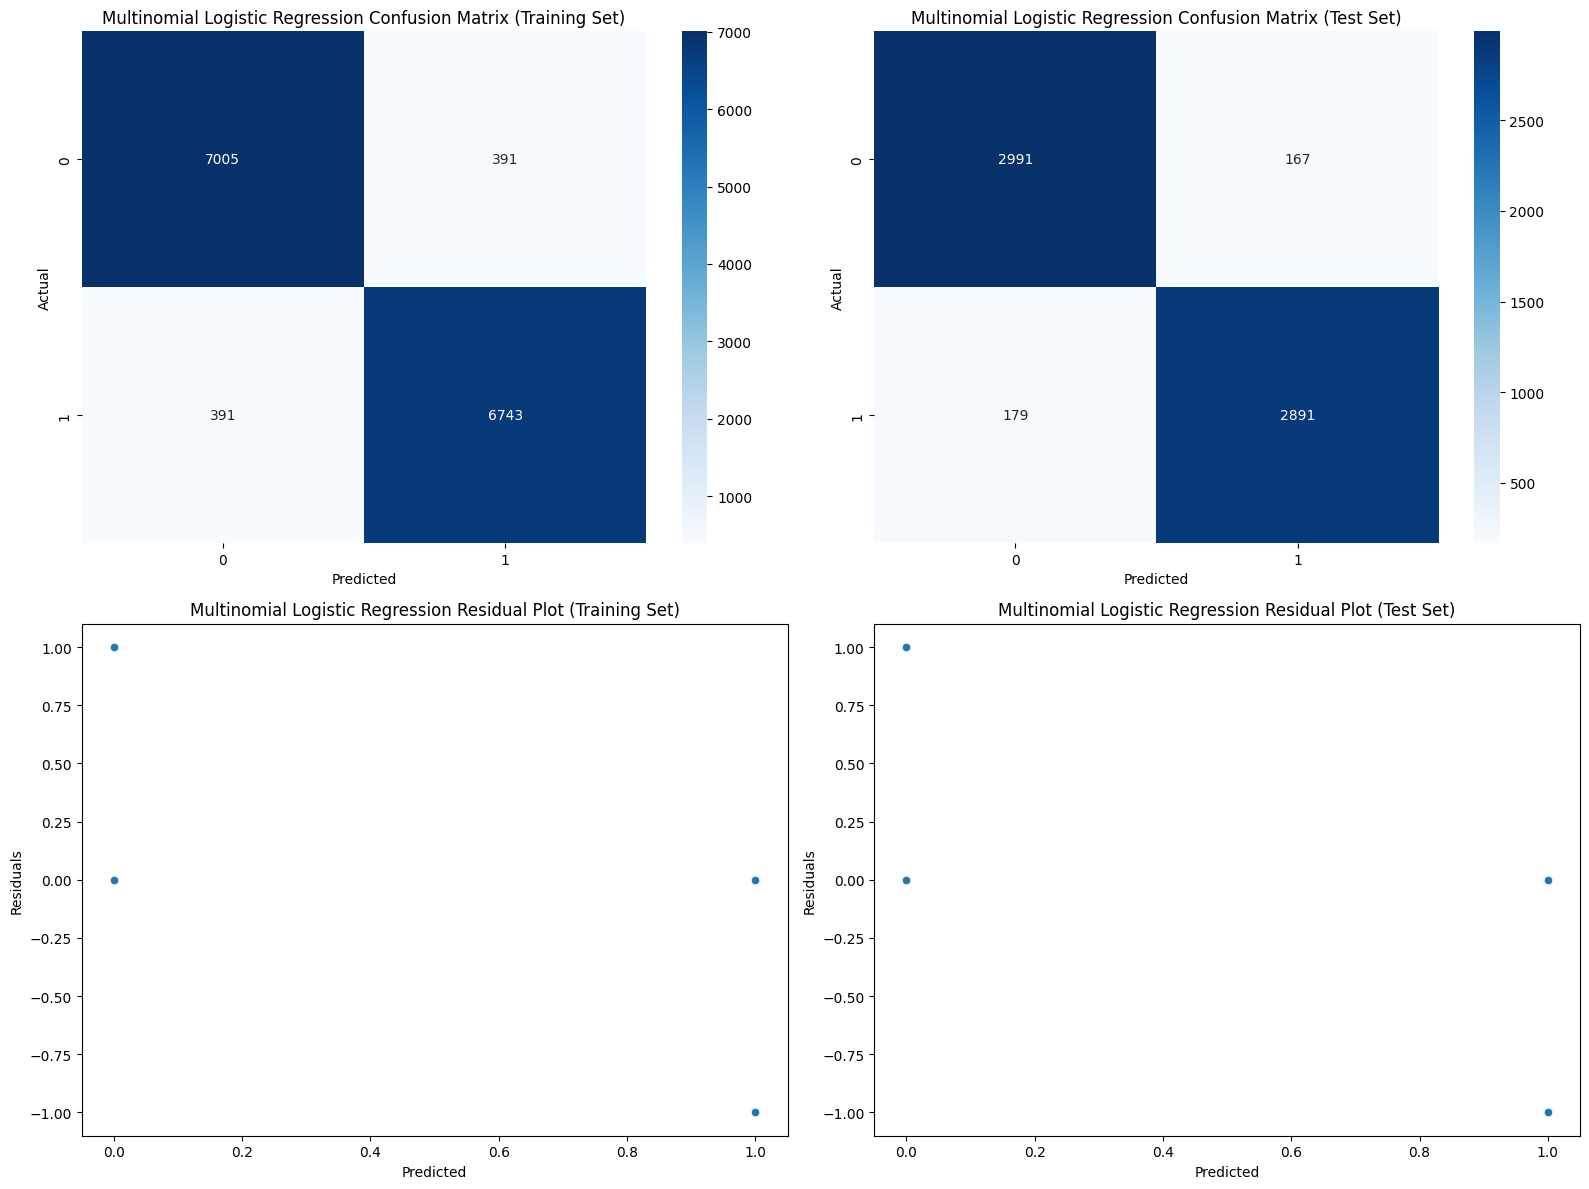

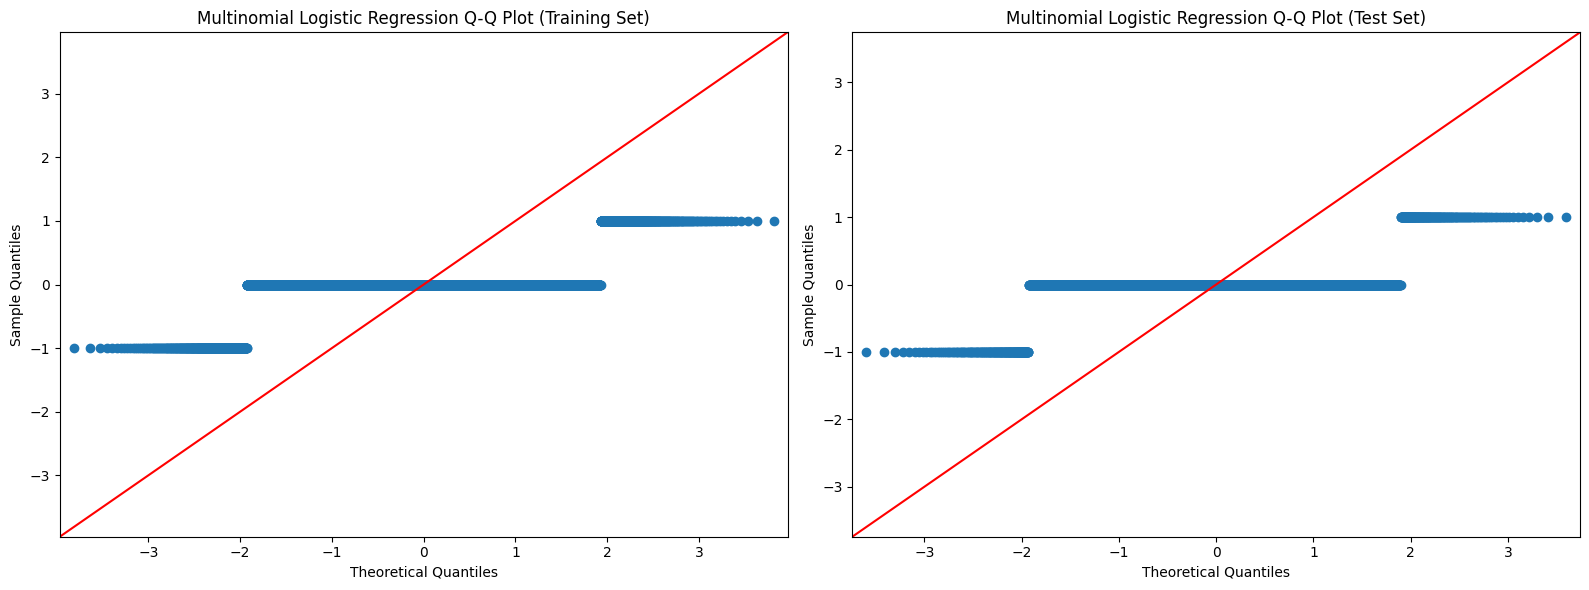

In [33]:
#===============================================================================
# 1. Multinomial Logistic Regression
#===============================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Import statsmodels for Q-Q Plots
import statsmodels.api as sm

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
y_pred_train_logreg, y_pred_test_logreg = evaluate_model(logreg, X_train, y_train, X_test, y_test, "Multinomial Logistic Regression")



Linear Discriminant Analysis Classification Report (Training Set):

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7396
           1       0.93      0.93      0.93      7134

    accuracy                           0.93     14530
   macro avg       0.93      0.93      0.93     14530
weighted avg       0.93      0.93      0.93     14530


Linear Discriminant Analysis Classification Report (Test Set):

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      3158
           1       0.93      0.92      0.93      3070

    accuracy                           0.93      6228
   macro avg       0.93      0.93      0.93      6228
weighted avg       0.93      0.93      0.93      6228



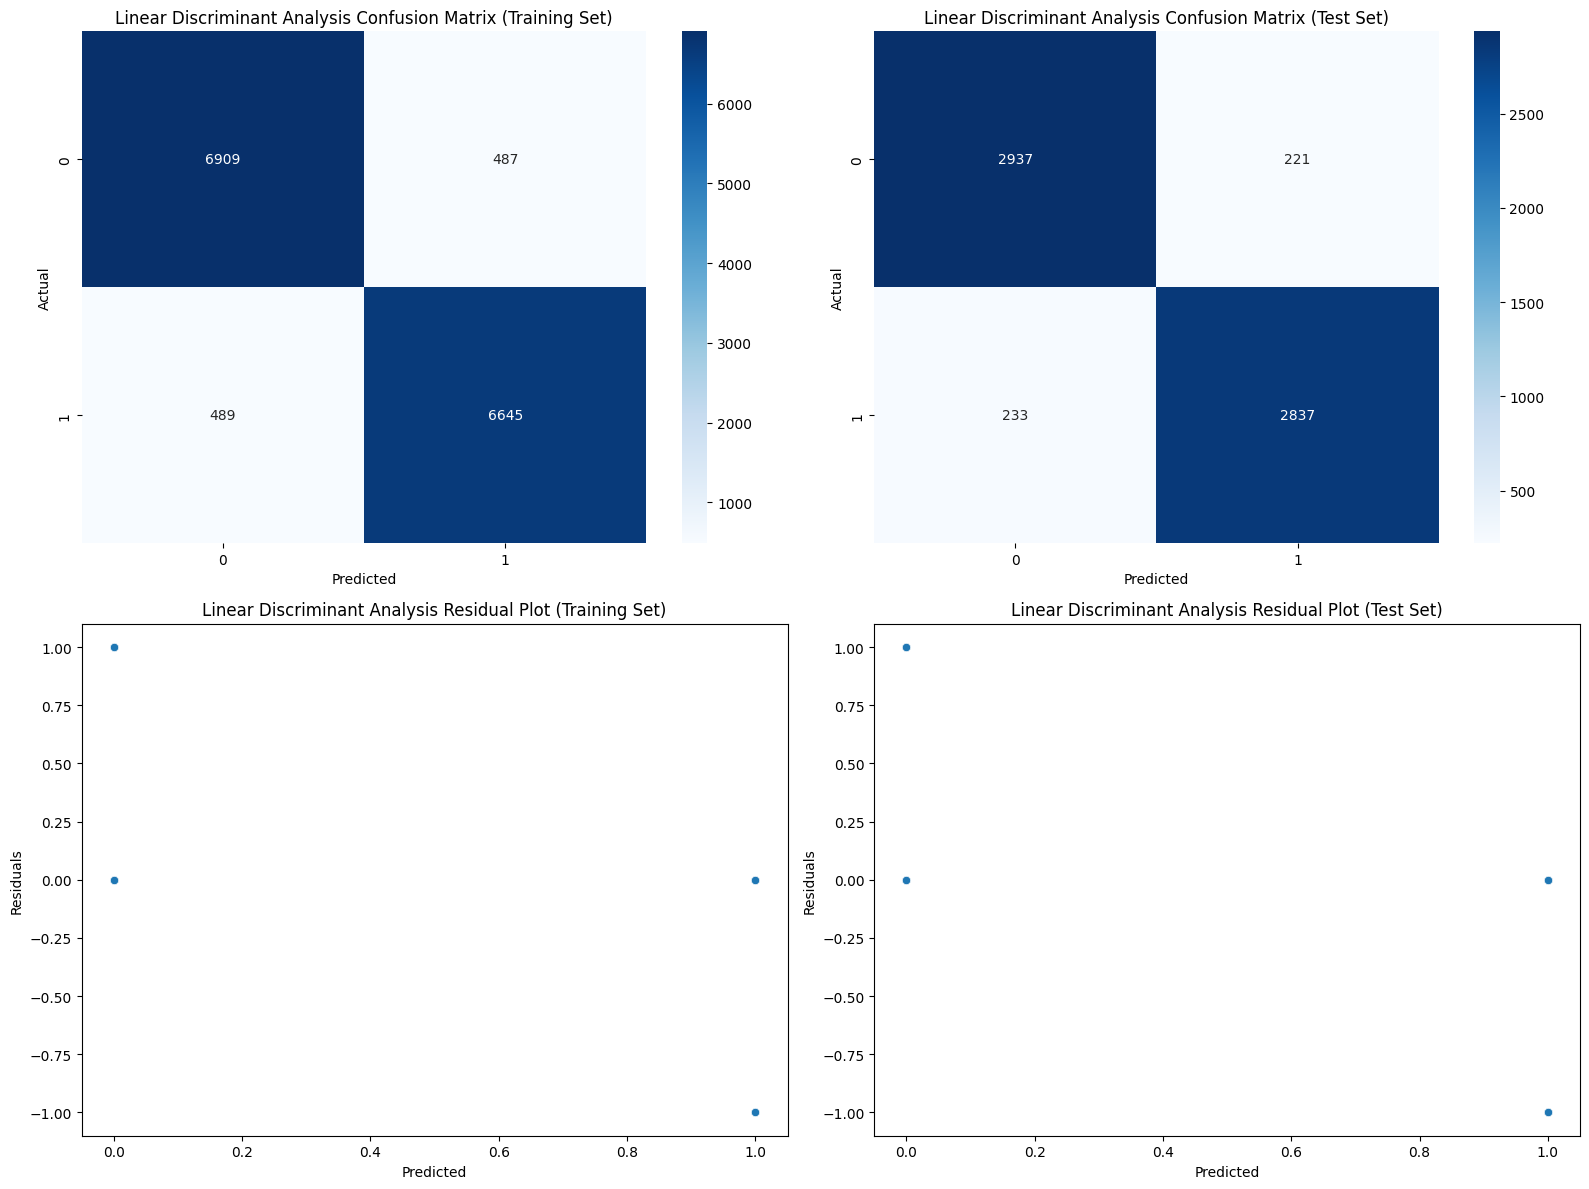

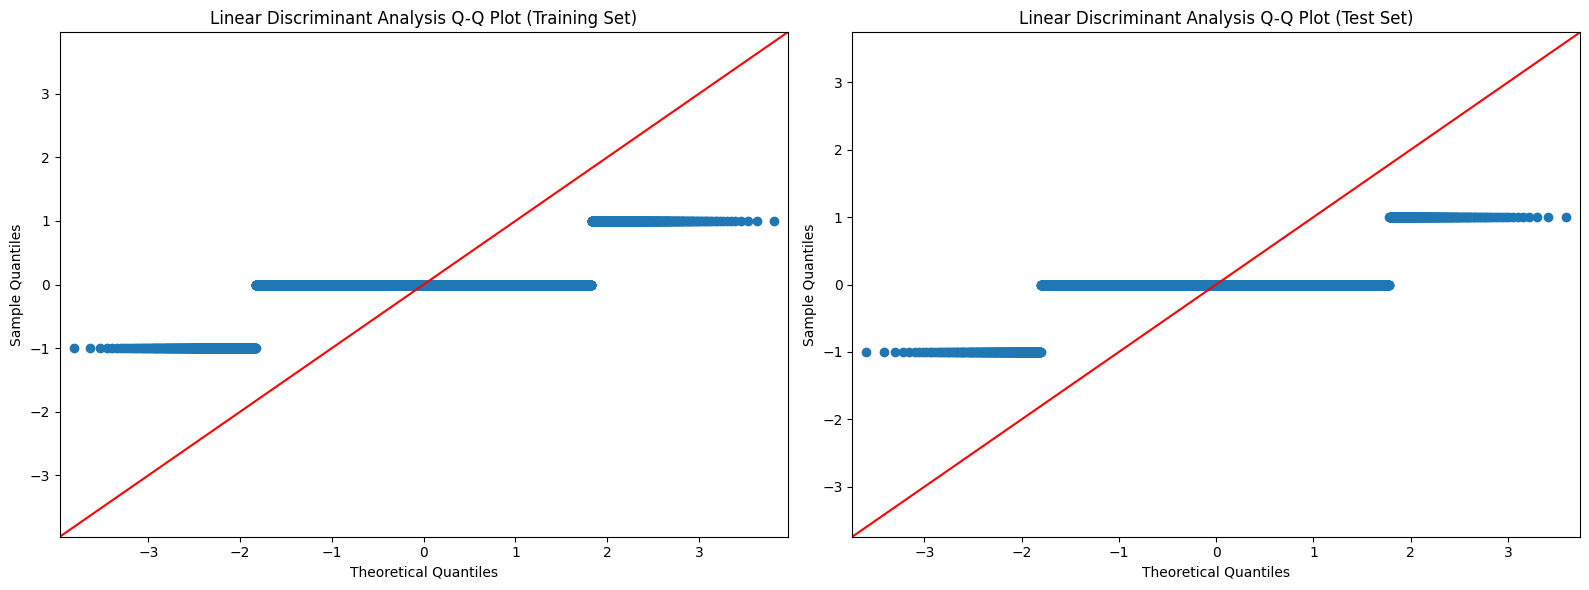

In [34]:
#===============================================================================
# Linear Discriminant Analysis (LDA)
#===============================================================================
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# 2. Linear Discriminant Analysis (LDA)
lda = LinearDiscriminantAnalysis()
y_pred_train_lda, y_pred_test_lda = evaluate_model(lda, X_train, y_train, X_test, y_test, "Linear Discriminant Analysis")




Quadratic Discriminant Analysis Classification Report (Training Set):

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      7396
           1       0.98      1.00      0.99      7134

    accuracy                           0.99     14530
   macro avg       0.99      0.99      0.99     14530
weighted avg       0.99      0.99      0.99     14530


Quadratic Discriminant Analysis Classification Report (Test Set):

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3158
           1       0.99      1.00      0.99      3070

    accuracy                           0.99      6228
   macro avg       0.99      0.99      0.99      6228
weighted avg       0.99      0.99      0.99      6228



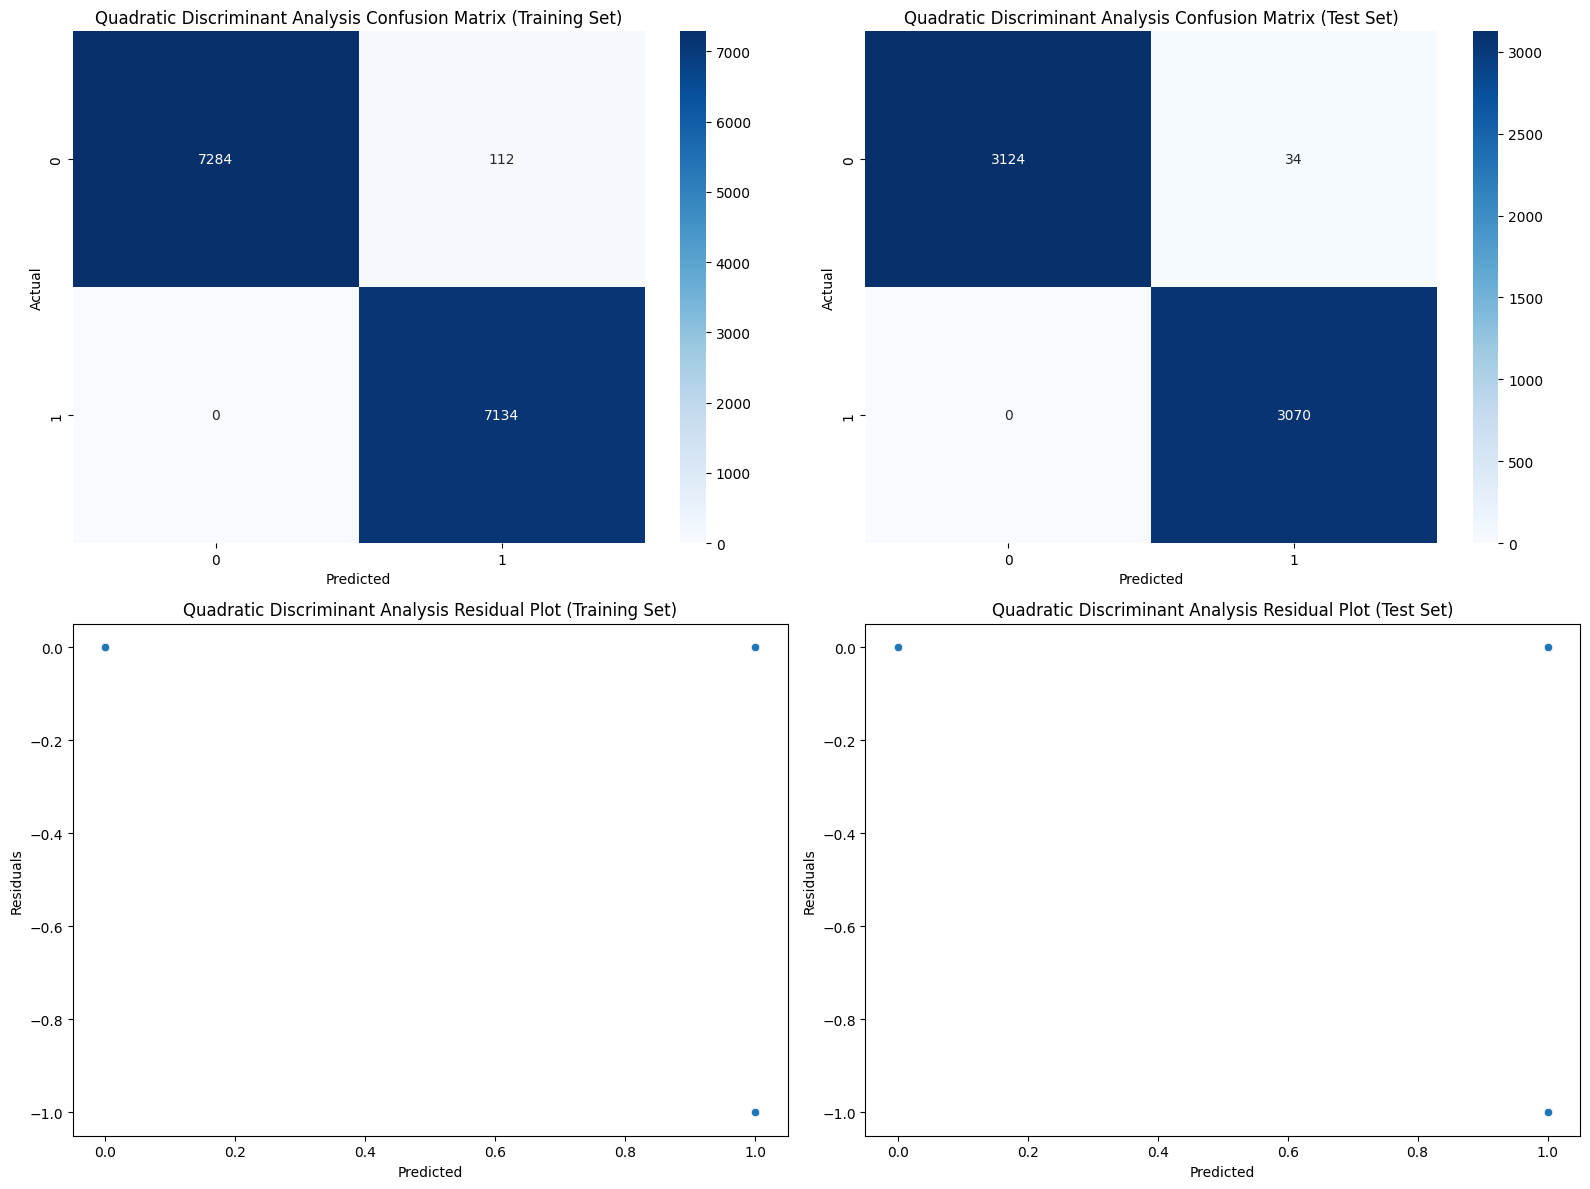

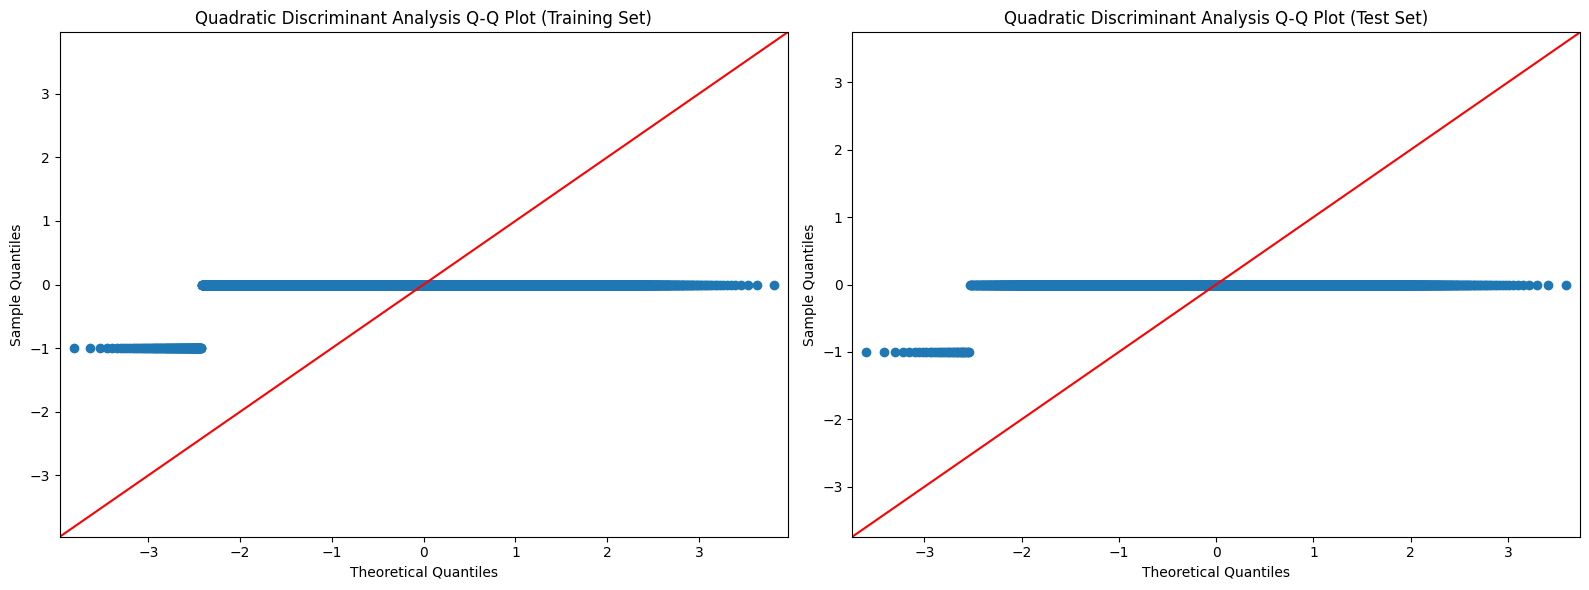

In [35]:
#===============================================================================
# Quadratic Discriminant Analysis (QDA)
#===============================================================================
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# 3. Quadratic Discriminant Analysis (QDA)
qda = QuadraticDiscriminantAnalysis()
y_pred_train_qda, y_pred_test_qda = evaluate_model(qda, X_train, y_train, X_test, y_test, "Quadratic Discriminant Analysis")





Naïve Bayes Classification Report (Training Set):

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      7396
           1       0.94      0.90      0.92      7134

    accuracy                           0.92     14530
   macro avg       0.92      0.92      0.92     14530
weighted avg       0.92      0.92      0.92     14530


Naïve Bayes Classification Report (Test Set):

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      3158
           1       0.94      0.90      0.92      3070

    accuracy                           0.92      6228
   macro avg       0.92      0.92      0.92      6228
weighted avg       0.92      0.92      0.92      6228



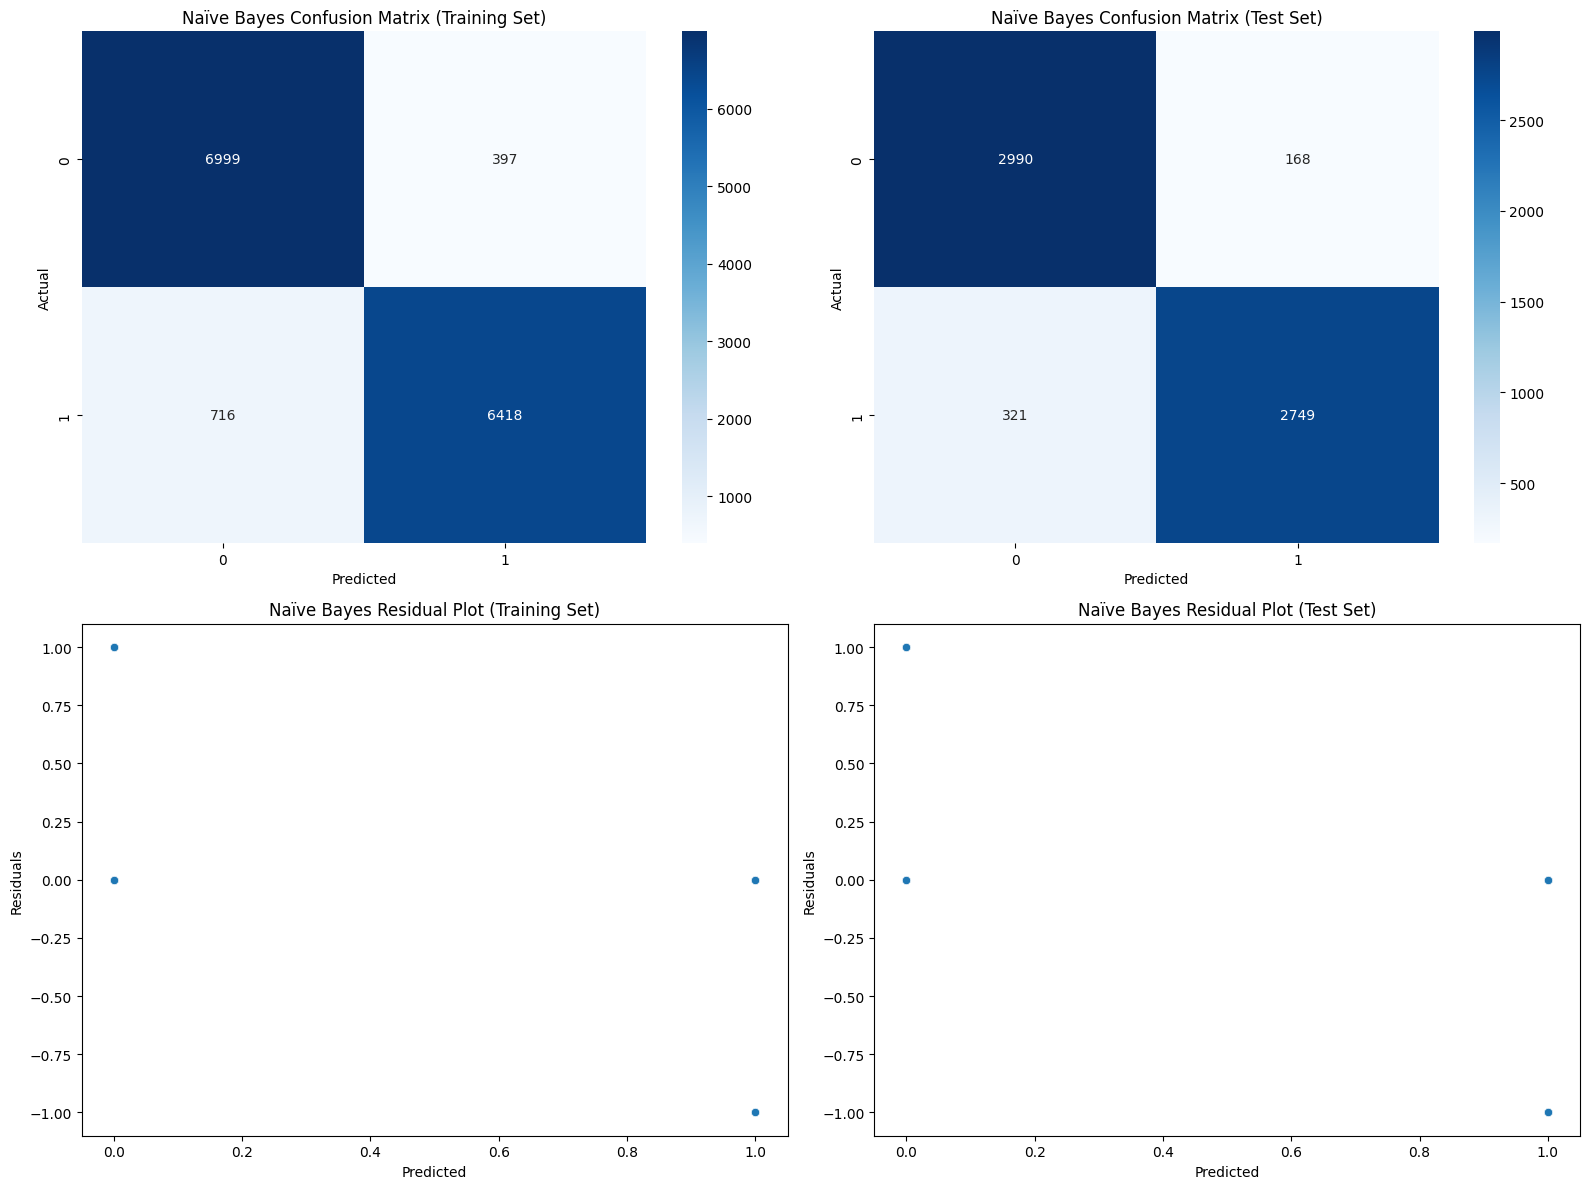

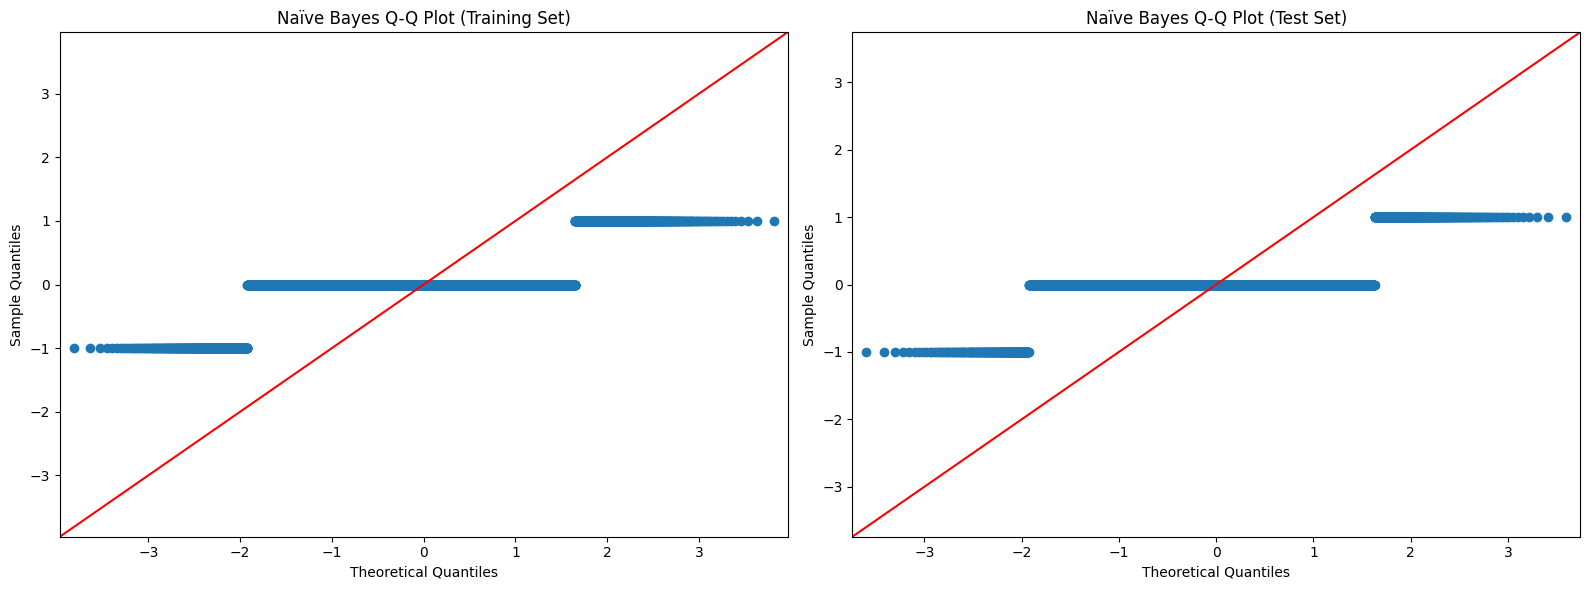

In [36]:
#===============================================================================
# Naïve Bayes
#===============================================================================
# 4. Naïve Bayes
nb = GaussianNB()
y_pred_train_nb, y_pred_test_nb = evaluate_model(nb, X_train, y_train, X_test, y_test, "Naïve Bayes")



Support Vector Machine Classification Report (Training Set):

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      7396
           1       0.94      0.95      0.95      7134

    accuracy                           0.95     14530
   macro avg       0.95      0.95      0.95     14530
weighted avg       0.95      0.95      0.95     14530


Support Vector Machine Classification Report (Test Set):

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      3158
           1       0.94      0.95      0.94      3070

    accuracy                           0.94      6228
   macro avg       0.94      0.94      0.94      6228
weighted avg       0.94      0.94      0.94      6228



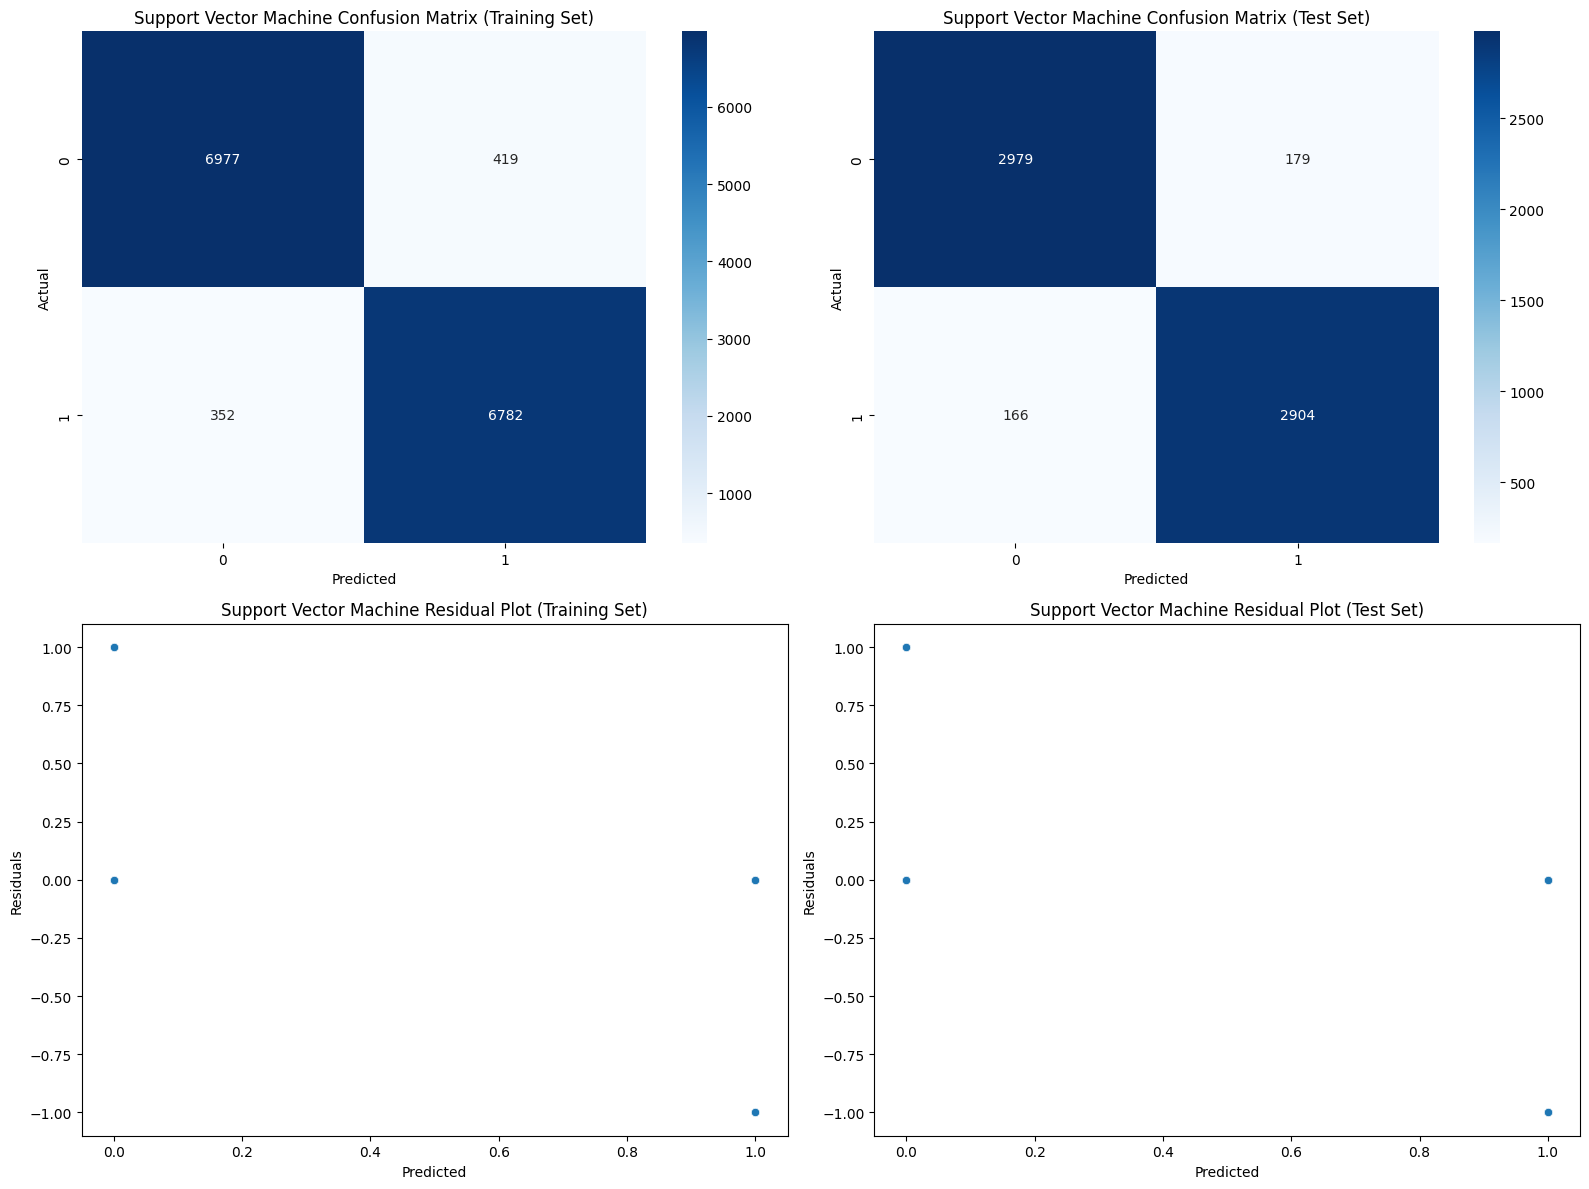

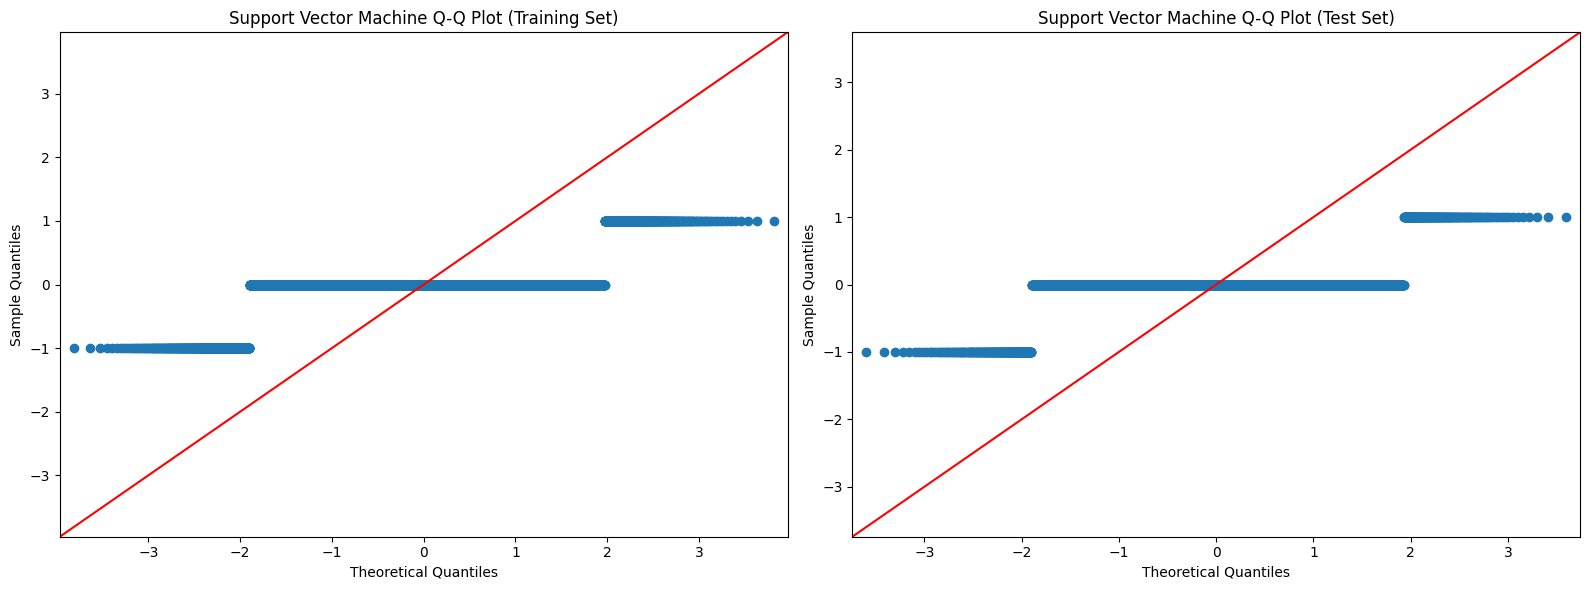

In [37]:
#===============================================================================
# Support Vector Machine (SVM)
#===============================================================================
from sklearn.svm import SVC
# 5. Support Vector Machine (SVM)
svm = SVC(kernel='linear')
y_pred_train_svm, y_pred_test_svm = evaluate_model(svm, X_train, y_train, X_test, y_test, "Support Vector Machine")


In [38]:
text="""Summary of Model Performance and Best Performer
The models demonstrated strong performance, with high accuracy, precision,
recall, and f1-scores. Multinomial Logistic Regression showed consistent
performance with an accuracy of 0.95 for the training set and 0.94 for the test
set. The Q-Q plots revealed deviations from normality, indicating potential
issues with model fit. Linear Discriminant Analysis (LDA) had an accuracy of
0.93 for both sets, with residuals also deviating from normal distribution in
the Q-Q plots. Quadratic Discriminant Analysis (QDA) achieved exceptional
performance with near-perfect accuracy of 0.99, though the Q-Q plots still
showed deviations. Naïve Bayes had an accuracy of 0.92 for both sets, with Q-Q
plots indicating non-normal residuals. Support Vector Machine (SVM) had an
accuracy of 0.95 for the training set and 0.94 for the test set, with Q-Q plots
showing deviations from normal distribution. Overall, QDA exhibited the highest
performance, with near-perfect accuracy and balanced precision and recall. This
superior performance can be attributed to its ability to model complex
relationships and non-linear decision boundaries more effectively than the other
models, making it the most robust model for this dataset. However, all models
showed strong results with specific areas for improvement based on the Q-Q plot
analyses."""

print(text)


Summary of Model Performance and Best Performer
The models demonstrated strong performance, with high accuracy, precision,
recall, and f1-scores. Multinomial Logistic Regression showed consistent
performance with an accuracy of 0.95 for the training set and 0.94 for the test
set. The Q-Q plots revealed deviations from normality, indicating potential
issues with model fit. Linear Discriminant Analysis (LDA) had an accuracy of
0.93 for both sets, with residuals also deviating from normal distribution in
the Q-Q plots. Quadratic Discriminant Analysis (QDA) achieved exceptional
performance with near-perfect accuracy of 0.99, though the Q-Q plots still
showed deviations. Naïve Bayes had an accuracy of 0.92 for both sets, with Q-Q
plots indicating non-normal residuals. Support Vector Machine (SVM) had an
accuracy of 0.95 for the training set and 0.94 for the test set, with Q-Q plots
showing deviations from normal distribution. Overall, QDA exhibited the highest
performance, with near-perfect

In [39]:
#===============================================================================
# Create submission DataFrames for each model
#===============================================================================
# Multinomial Logistic Regression Submission
submission_train_logreg = pd.DataFrame({
    'Id': X_train.index,
    'Model': 'Logistic Regression',
    'Predicted': y_pred_train_logreg
})
submission_test_logreg = pd.DataFrame({
    'Id': X_test.index,
    'Model': 'Logistic Regression',
    'Predicted': y_pred_test_logreg
})

# Linear Discriminant Analysis Submission
submission_train_lda = pd.DataFrame({
    'Id': X_train.index,
    'Model': 'Linear Discriminant Analysis',
    'Predicted': y_pred_train_lda
})
submission_test_lda = pd.DataFrame({
    'Id': X_test.index,
    'Model': 'Linear Discriminant Analysis',
    'Predicted': y_pred_test_lda
})

# Quadratic Discriminant Analysis Submission
submission_train_qda = pd.DataFrame({
    'Id': X_train.index,
    'Model': 'Quadratic Discriminant Analysis',
    'Predicted': y_pred_train_qda
})
submission_test_qda = pd.DataFrame({
    'Id': X_test.index,
    'Model': 'Quadratic Discriminant Analysis',
    'Predicted': y_pred_test_qda
})

# Naïve Bayes Submission
submission_train_nb = pd.DataFrame({
    'Id': X_train.index,
    'Model': 'Naïve Bayes',
    'Predicted': y_pred_train_nb
})
submission_test_nb = pd.DataFrame({
    'Id': X_test.index,
    'Model': 'Naïve Bayes',
    'Predicted': y_pred_test_nb
})

# Support Vector Machine Submission
submission_train_svm = pd.DataFrame({
    'Id': X_train.index,
    'Model': 'Support Vector Machine',
    'Predicted': y_pred_train_svm
})
submission_test_svm = pd.DataFrame({
    'Id': X_test.index,
    'Model': 'Support Vector Machine',
    'Predicted': y_pred_test_svm
})

#===============================================================================
# Save submissions to CSV files
#===============================================================================
# Save training set submissions
submission_train_logreg.to_csv('submission_train_logreg.csv', index=False)
submission_train_lda.to_csv('submission_train_lda.csv', index=False)
submission_train_qda.to_csv('submission_train_qda.csv', index=False)
submission_train_nb.to_csv('submission_train_nb.csv', index=False)
submission_train_svm.to_csv('submission_train_svm.csv', index=False)

# Save test set submissions
submission_test_logreg.to_csv('submission_test_logreg.csv', index=False)
submission_test_lda.to_csv('submission_test_lda.csv', index=False)
submission_test_qda.to_csv('submission_test_qda.csv', index=False)
submission_test_nb.to_csv('submission_test_nb.csv', index=False)
submission_test_svm.to_csv('submission_test_svm.csv', index=False)